# Airbnb

En este notebook se intenta predecir con máxima exactitud el precio perfecto de un Airbnb en función de sus características.

Práctica realizada por Ana Sanuy Garabatos, Ángela Corchero Corral, Begoña Cabañas Agudo, Naomi Petreaca, Sergio Moreno González y Tomás Vela Angulo.

## 1. Preprocessing básico

In [1]:
#Cargamos las librerias:

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
import scipy.stats as ss

sns.set()
#pip install style
#style.use('ggplot') or plt.style.use('ggplot')
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"

In [2]:
#Recomendamos guargar el csv en la misma carpeta que el ipynb
data = pd.read_csv('airbnb-listings-extract.csv',sep=';')

Es importante visualizar cómo es nuestra base de datos

In [3]:
data.head()

ID                            Listing Url       Scrape ID  \
0  11210388  https://www.airbnb.com/rooms/11210388  20170306202425   
1  17471131  https://www.airbnb.com/rooms/17471131  20170407214050   
2  17584891  https://www.airbnb.com/rooms/17584891  20170407214050   
3   5398030   https://www.airbnb.com/rooms/5398030  20170407214050   
4  18104606  https://www.airbnb.com/rooms/18104606  20170407214050   

  Last Scraped                                 Name  \
0   2017-03-07       The Loft-Full Bath-Deck w/View   
1   2017-04-08           Claris I, Friendly Rentals   
2   2017-04-08  Style Terrace Red, Friendly Rentals   
3   2017-04-08    Picasso Suite 1.4 Paseo de Gracia   
4   2017-04-08       Smart City Centre Apartment II   

                                             Summary  \
0  Loft in the Hill country 12-15 minutes directl...   
1  This apartment has: 1 double bed, 1 double sof...   
2  This apartment has: 1 double bed, 1 double sof...   
3  Live like a local in Barcelona's most chic dis...   
4  Unique apartment in vibrant neighborhoods, car...   

                                               Space  \
0  This loft has a spectacular view of the hills ...   
1  This apartment has: 1 double bed, 1 double sof...   
2  This apartment has: 1 double bed, 1 double sof...   
3  You wake up to the sun rising over Barcelona's...   
4  License: HUTB-005313 Charming apartment, locat...   

                                         Description Experiences Offered  \
0  Loft in the Hill country 12-15 minutes directl...                none   
1  This apartment has: 1 double bed, 1 double sof...                none   
2  This apartment has: 1 double bed, 1 double sof...                none   
3  Live like a local in Barcelona's most chic dis...                none   
4  Unique apartment in vibrant neighborhoods, car...                none   

                               Neighborhood Overview  ...  \
0  This neighborhood is located in the hills west...  ...   
1  Plaza   Cataluña Catalonia Square is the large...  ...   
2  Plaza   Cataluña Catalonia Square is the large...  ...   
3  We're right in the heart of the chic L'Eixampl...  ...   
4                                                NaN  ...   

  Review Scores Communication Review Scores Location Review Scores Value  \
0                        10.0                   10.0                10.0   
1                        10.0                    8.0                10.0   
2                         NaN                    NaN                 NaN   
3                        10.0                   10.0                 9.0   
4                         NaN                    NaN                 NaN   

       License Jurisdiction Names Cancellation Policy  \
0          NaN                NaN            moderate   
1  HUTB-006721                NaN     super_strict_30   
2  HUTB-007527                NaN     super_strict_30   
3          NaN                NaN              strict   
4          NaN                NaN            flexible   

  Calculated host listings count Reviews per Month  \
0                            1.0              3.50   
1                          106.0              0.86   
2                          106.0               NaN   
3                           24.0              1.09   
4                           92.0               NaN   

                    Geolocation  \
0  30.3373609355,-97.8632766782   
1   41.3896829422,2.17262543017   
2   41.3930345489,2.16217327868   
3    41.3969668101,2.1674178103   
4   41.3886851936,2.15514963616   

                                            Features  
0  Host Is Superhost,Host Has Profile Pic,Host Id...  
1  Host Has Profile Pic,Requires License,Instant ...  
2  Host Has Profile Pic,Requires License,Instant ...  
3  Host Has Profile Pic,Host Identity Verified,Re...  
4  Host Has Profile Pic,Host Identity Verified,Is...  

[5 rows x 89 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14780 entries, 0 to 14779
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              14780 non-null  int64  
 1   Listing Url                     14780 non-null  object 
 2   Scrape ID                       14780 non-null  int64  
 3   Last Scraped                    14780 non-null  object 
 4   Name                            14779 non-null  object 
 5   Summary                         14189 non-null  object 
 6   Space                           10888 non-null  object 
 7   Description                     14774 non-null  object 
 8   Experiences Offered             14780 non-null  object 
 9   Neighborhood Overview           9134 non-null   object 
 10  Notes                           5644 non-null   object 
 11  Transit                         9066 non-null   object 
 12  Access                          

Nuestra base de datos cuenta con 14780 observaciones en las que se recoge la información de 89 variables. Dentro del conjunto de variables, únicamente 36 son numéricas, por lo que habrá que estudiar qué hacer con ellas. Habrá que eliminar variables compuestas por string que sean imposibles de incluir en la construcción de nuestros modelos. 

Eliminamos variables que a simple vista se observa que serán irrelevantes para la construcción de un evaluador de precios. Muchas serán eliminadas por contener grandes descripciones en forma de string que será inviable trasladar a un modelo predictivo. Variables que contengan información de fechas como First Review, Last Review y Calendar last Scraped serán retiradas. Otras como latitud, longitud y geolocation por ser información que consideramos sin relevancia. Square Feet, Host Acceptance Rate y Has Availability tienen 598, 39 y 12 observaciones no nulas respectivamente, no tendría sentido imputar sus valores por lo que las retiramos del análisis. 

Observamos que las variables Weekly Price y Monthly Price tienen una cantidad de valores nulos también muy alta. Además, no queremos que nuestro se entrene con variables que contengan la misma información que nuestra variable objetivo (Price). Es por esto que esperaremos a calcular la matriz de correlaciones para considerar eliminarlas del dataset.

In [5]:
data=data.drop(data.columns[[0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,27,28,29,30,34,35,36,37,40,43,45,55,46,66,71,73,74,82,83,87,88]],axis=1)

Cargamos la información del dataset tras eliminar 44 variables. 

In [6]:
data.head()

Experiences Offered  Host Since Host Response Time  Host Response Rate  \
0                none  2016-02-11     within an hour               100.0   
1                none  2016-11-08     within an hour               100.0   
2                none  2016-11-08     within an hour               100.0   
3                none  2010-05-25     within an hour               100.0   
4                none  2016-01-12     within an hour                99.0   

   Host Listings Count  Host Total Listings Count  \
0                  1.0                        1.0   
1                162.0                      162.0   
2                162.0                      162.0   
3                 27.0                       27.0   
4                207.0                      207.0   

                                  Host Verifications       City      State  \
0                            email,phone,reviews,kba     Austin         TX   
1                     email,phone,reviews,work_email  Barcelona  Barcelona   
2                     email,phone,reviews,work_email  Barcelona  Barcelona   
3  email,phone,facebook,reviews,manual_offline,ju...  Barcelona  Barcelona   
4                          email,phone,reviews,jumio  Barcelona  Catalunya   

      Market  ... Review Scores Rating Review Scores Accuracy  \
0     Austin  ...                 98.0                   10.0   
1  Barcelona  ...                 80.0                    8.0   
2  Barcelona  ...                  NaN                    NaN   
3  Barcelona  ...                 92.0                   10.0   
4  Barcelona  ...                  NaN                    NaN   

  Review Scores Cleanliness Review Scores Checkin  \
0                      10.0                  10.0   
1                      10.0                  10.0   
2                       NaN                   NaN   
3                       9.0                  10.0   
4                       NaN                   NaN   

   Review Scores Communication  Review Scores Location  Review Scores Value  \
0                         10.0                    10.0                 10.0   
1                         10.0                     8.0                 10.0   
2                          NaN                     NaN                  NaN   
3                         10.0                    10.0                  9.0   
4                          NaN                     NaN                  NaN   

   Cancellation Policy Calculated host listings count Reviews per Month  
0             moderate                            1.0              3.50  
1      super_strict_30                          106.0              0.86  
2      super_strict_30                          106.0               NaN  
3               strict                           24.0              1.09  
4             flexible                           92.0               NaN  

[5 rows x 45 columns]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14780 entries, 0 to 14779
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Experiences Offered             14780 non-null  object 
 1   Host Since                      14777 non-null  object 
 2   Host Response Time              12881 non-null  object 
 3   Host Response Rate              12881 non-null  float64
 4   Host Listings Count             14777 non-null  float64
 5   Host Total Listings Count       14777 non-null  float64
 6   Host Verifications              14774 non-null  object 
 7   City                            14774 non-null  object 
 8   State                           14636 non-null  object 
 9   Market                          14723 non-null  object 
 10  Smart Location                  14780 non-null  object 
 11  Country                         14779 non-null  object 
 12  Property Type                   

Tras una limpieza inicial, nuestro dataset ha pasado a estar compuesto por 45 variables. De estas, 15 siguen sin ser numéricas. Más adelante comprobaremos si es posible categorizarlas o su composición hace que se deban eliminar del análisis.

Ahora veamos cómo se distribuyen las variables:

In [8]:
data.describe().T

count         mean          std     min  \
Host Response Rate              12881.0    94.823461    15.215988    0.00   
Host Listings Count             14777.0    12.513636    34.090223    0.00   
Host Total Listings Count       14777.0    12.513636    34.090223    0.00   
Accommodates                    14780.0     3.277808     2.097291    1.00   
Bathrooms                       14725.0     1.281732     0.658517    0.00   
Bedrooms                        14755.0     1.343816     0.900078    0.00   
Beds                            14731.0     2.044260     1.612770    1.00   
Price                           14763.0    73.561471    72.062050    9.00   
Weekly Price                     3590.0   376.937883   195.701043   70.00   
Monthly Price                    3561.0  1426.125246  1246.403853  250.00   
Security Deposit                 6256.0   189.226822   115.151070    0.00   
Cleaning Fee                     8687.0    31.805341    30.878599    0.00   
Guests Included                 14780.0     1.589986     1.182550    0.00   
Extra People                    14780.0     7.690460    12.971352    0.00   
Minimum Nights                  14780.0     3.050474    12.266517    1.00   
Maximum Nights                  14780.0   945.168742  8439.321218    1.00   
Availability 30                 14780.0     8.954736     9.333252    0.00   
Availability 60                 14780.0    22.996211    19.731371    0.00   
Availability 90                 14780.0    39.869621    29.621456    0.00   
Availability 365                14780.0   202.104465   127.886822    0.00   
Number of Reviews               14780.0    22.632273    38.290244    0.00   
Review Scores Rating            11476.0    91.697978     8.989101   20.00   
Review Scores Accuracy          11454.0     9.416012     0.921938    2.00   
Review Scores Cleanliness       11460.0     9.328883     0.989933    2.00   
Review Scores Checkin           11443.0     9.621778     0.802736    2.00   
Review Scores Communication     11460.0     9.647033     0.767116    2.00   
Review Scores Location          11440.0     9.532168     0.774527    2.00   
Review Scores Value             11439.0     9.218201     0.950578    2.00   
Calculated host listings count  14776.0     9.486871    23.626014    1.00   
Reviews per Month               11618.0     1.870014     1.867550    0.02   

                                   25%     50%      75%         max  
Host Response Rate              100.00   100.0   100.00      100.00  
Host Listings Count               1.00     2.0     6.00      519.00  
Host Total Listings Count         1.00     2.0     6.00      519.00  
Accommodates                      2.00     3.0     4.00       16.00  
Bathrooms                         1.00     1.0     1.00        8.00  
Bedrooms                          1.00     1.0     2.00       10.00  
Beds                              1.00     2.0     2.00       16.00  
Price                            34.00    55.0    86.00      999.00  
Weekly Price                    215.00   350.0   500.00      999.00  
Monthly Price                   720.00  1200.0  1725.00    25000.00  
Security Deposit                100.00   150.0   200.00      990.00  
Cleaning Fee                     15.00    25.0    40.00      662.00  
Guests Included                   1.00     1.0     2.00       16.00  
Extra People                      0.00     0.0    15.00      500.00  
Minimum Nights                    1.00     2.0     3.00     1125.00  
Maximum Nights                  365.00  1125.0  1125.00  1000000.00  
Availability 30                   0.00     6.0    14.00       30.00  
Availability 60                   4.00    20.0    38.00       60.00  
Availability 90                  12.00    38.0    65.00       90.00  
Availability 365                 78.00   239.0   319.00      365.00  
Number of Reviews                 1.00     7.0    27.00      446.00  
Review Scores Rating             89.00    94.0    98.00      100.00  
Review Scores Accuracy            9.

Estudiaremos los valores nulos por variable. Más adelante consideraremos si es necesario imputar.

In [9]:
data.isna().sum()

Experiences Offered                   0
Host Since                            3
Host Response Time                 1899
Host Response Rate                 1899
Host Listings Count                   3
Host Total Listings Count             3
Host Verifications                    6
City                                  6
State                               144
Market                               57
Smart Location                        0
Country                               1
Property Type                         0
Room Type                             0
Accommodates                          0
Bathrooms                            55
Bedrooms                             25
Beds                                 49
Bed Type                              0
Amenities                           170
Price                                17
Weekly Price                      11190
Monthly Price                     11219
Security Deposit                   8524
Cleaning Fee                       6093


También analizaremos la cantidad de valores únicos por variable. Con esto nos podemos hacer una idea de qué variables son categóricas. 

In [10]:
data.nunique()

Experiences Offered                   5
Host Since                         2116
Host Response Time                    4
Host Response Rate                   70
Host Listings Count                  56
Host Total Listings Count            56
Host Verifications                  206
City                                246
State                               102
Market                               43
Smart Location                      257
Country                              17
Property Type                        22
Room Type                             3
Accommodates                         16
Bathrooms                            17
Bedrooms                             10
Beds                                 16
Bed Type                              5
Amenities                         12379
Price                               370
Weekly Price                        388
Monthly Price                       586
Security Deposit                    124
Cleaning Fee                        111


Vamos a analizar en mayor profundidad las variables City, State, Market y Smart Location para decidir qué hacer con ellas.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 39532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 24503 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 37324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 33258 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 27835 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 21306 missing from c

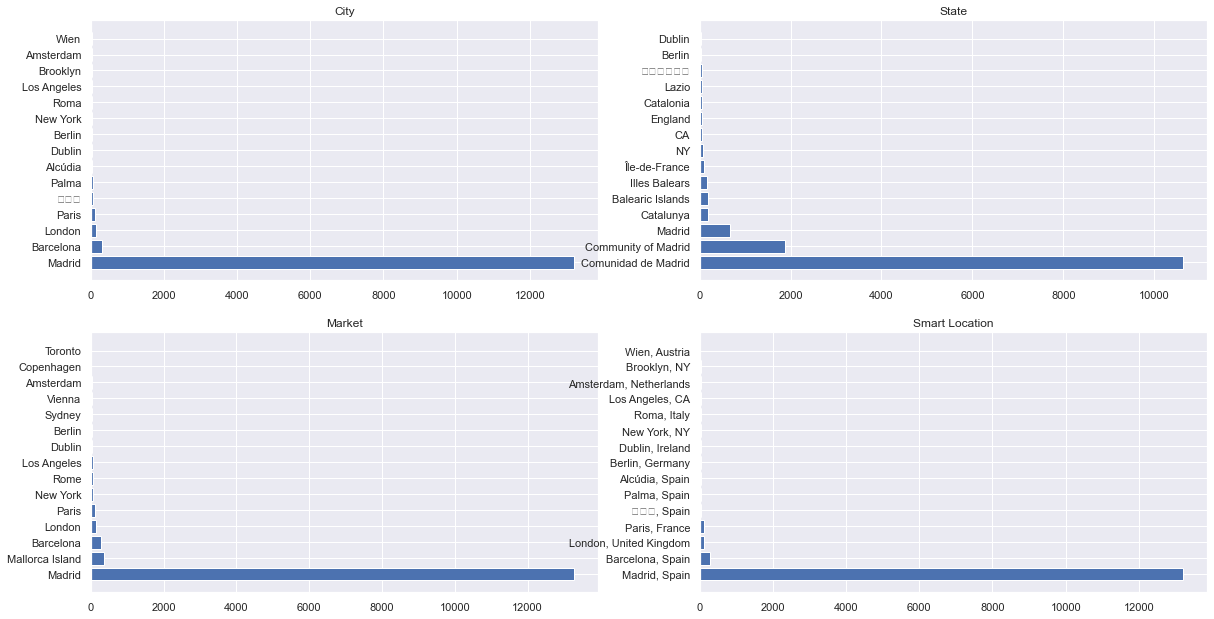

In [11]:
plt.figure(figsize=(20, 22))

plt.subplot(4, 2, 1)
plt.barh(data['City'].value_counts()[:15].index, data['City'].value_counts()[:15])
plt.gca().set_title('City')

plt.subplot(4, 2, 2)
plt.barh(data['State'].value_counts()[:15].index, data['State'].value_counts()[:15])
plt.gca().set_title('State')

plt.subplot(4, 2, 3)
plt.barh(data['Market'].value_counts()[:15].index, data['Market'].value_counts()[:15])
plt.gca().set_title('Market')

plt.subplot(4, 2, 4)
plt.barh(data['Smart Location'].value_counts()[:15].index, data['Smart Location'].value_counts()[:15])
plt.gca().set_title('Smart Location')

plt.show()

Presentan problemas de estructura. Podemos encontrar dos veces la misma ciudad en las variables pero escrita de forma distinta, como es el caso de Madrid o Palma. Además, observamos cómo están todas enormemente desbalanceadas por estar casi todos los alojamientos situados en Madrid. Estos dos problemas se evidencian de forma clara en la variable State, en la que las tres categorías con más observaciones son Comunidad de Madrid, Community of Madrid y Madrid. 

Dejaremos únicamente la variable City, ya que solo presenta 6 valores nulos y no observamos que ocurra el problema de la repetición de localizaciones registradas con nombres distintos. Aún así, por la gran cantidad de valores distintos que componen la variable city y el gran desbalanceo de Madrid, no creemos que vaya a incluirse en ningún modelo, tendrá una función descriptiva.

In [12]:
data=data.drop(['State','Market','Smart Location'],axis=1)

### Representación gráfica de las variables

Para terminar el análisis descriptivo de las variables, representaremos las continuas en forma de histograma y boxplot y las categóricas en gráficos de barras.

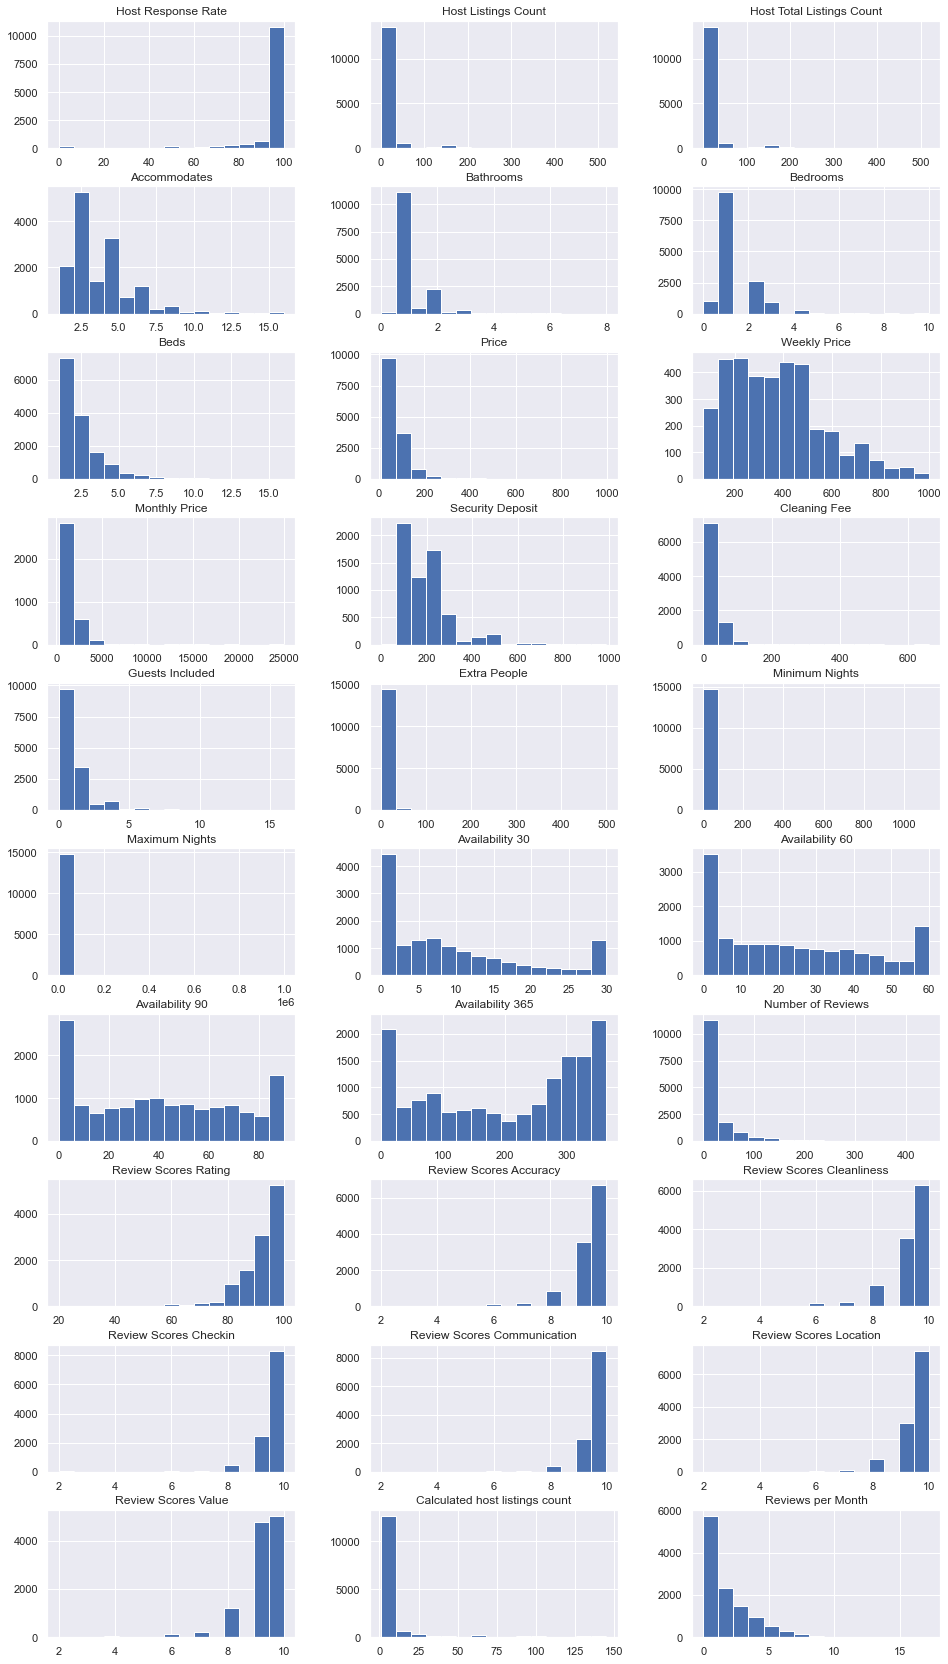

In [13]:
data.hist(figsize=(16,48),layout=(16,3),bins=15) 
plt.show()

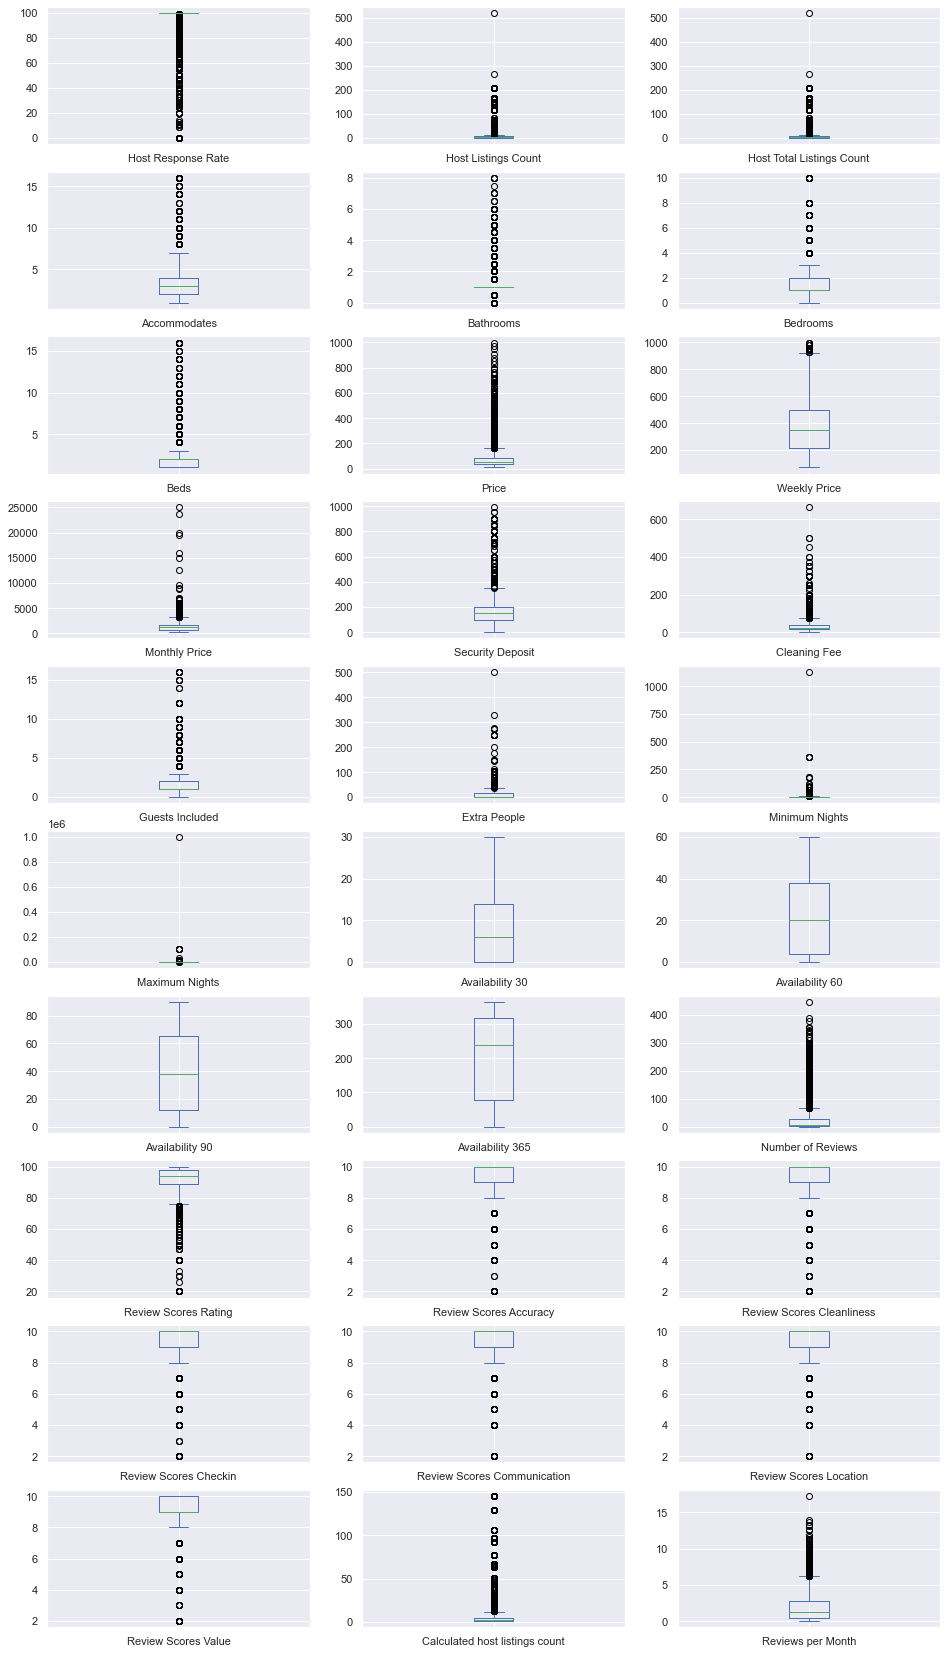

In [14]:
data.plot(figsize=(16,48),kind='box', subplots=True,layout=(16,3),sharex=False, sharey=False)
plt.show()

Vamos a analizar los outliers en más detalle.

Comenzaremos con Maximum Nights:

<AxesSubplot:xlabel='Maximum Nights'>

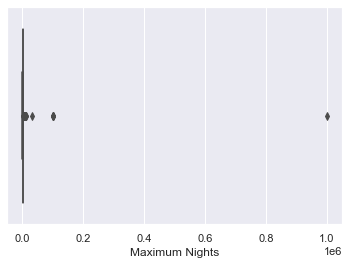

In [15]:
sns.boxplot(x=data['Maximum Nights'])

In [16]:
data['Maximum Nights'].max()

1000000

Vamos a retirar el outlier por poder ser un punto potencialmente muy influyente a la hora de construir los modelos.
Hay tres outliers claros en la variable Maximum Nights, uno con un valor de 1000000, otro de 100000 y otro de 30000. Los tres son potencialmente muy influyentes a la hora de construir modelos y son datos absurdos, ya que representan tiempos ilógicos para evaluar el tiempo de alojamiento de los clientes (70 años equivalen a 25550 días)

In [17]:
data = data[(data['Maximum Nights']<29999)]

<AxesSubplot:xlabel='Maximum Nights'>

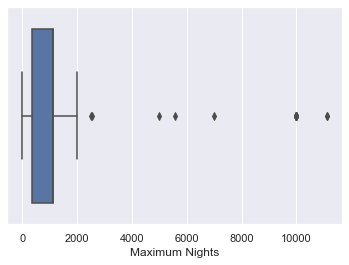

In [18]:
sns.boxplot(x=data['Maximum Nights'])

Sigue habiendo outliers en la variable, pero no tienen tanto peso como el que pudieran tener los dos que hemos retirado.

Continuamos analizando Minimum Nights:

<AxesSubplot:xlabel='Minimum Nights'>

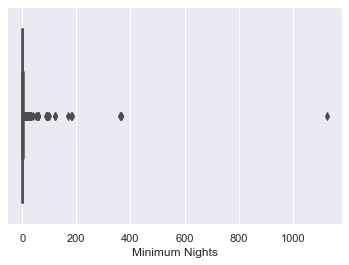

In [19]:
sns.boxplot(x=data['Minimum Nights'])

In [20]:
data['Minimum Nights'].max()

1125

En esta variable también hay varios outliers, con uno de ellos muy evidente. Lo retiramos primero y luego analizaremos los datos sin ese punto para considerar retirar algún punto más de la variable.

In [21]:
data = data[(data['Minimum Nights']<1124)]

<AxesSubplot:xlabel='Minimum Nights'>

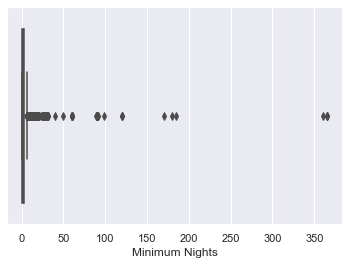

In [22]:
sns.boxplot(x=data['Minimum Nights'])

Sigue habiendo dos outliers que pueden tener mucho peso en la variable. Los retiraremos también.

In [23]:
data = data[(data['Minimum Nights']<300)]

<AxesSubplot:xlabel='Minimum Nights'>

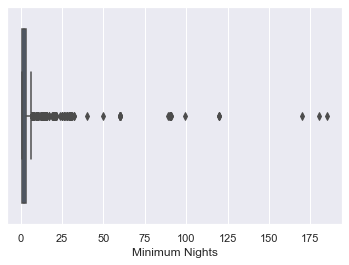

In [24]:
sns.boxplot(x=data['Minimum Nights'])

Sigue habiendo una gran cantidad de outliers en la variable. No retiraremos más, ya que esto se debe a que la gran mayoría de los alojamientos tienen un mínimo de 3 días a lo sumo de estancia (el tercer cuartil es de 3 días), lo que hace que al representar los datos en forma de boxplot, todas las observaciones que tengan valores en Minimum Nights 1.5 veces mayores al rango intercuartílico se consideren outliers.

Estudiando las variables Minimum Nights y Maximum Nights, nos parece que podría ser interesante hacer un análisis del precio unicamente a los alojamientos para estancias cortas. Más adelante se probará a construir modelos para este grupo de datos en específico.

Finalmente, representamos las variables categóricas en gráficos de barras y vemos cómo se distribuyen los datos en sus distintas categorías

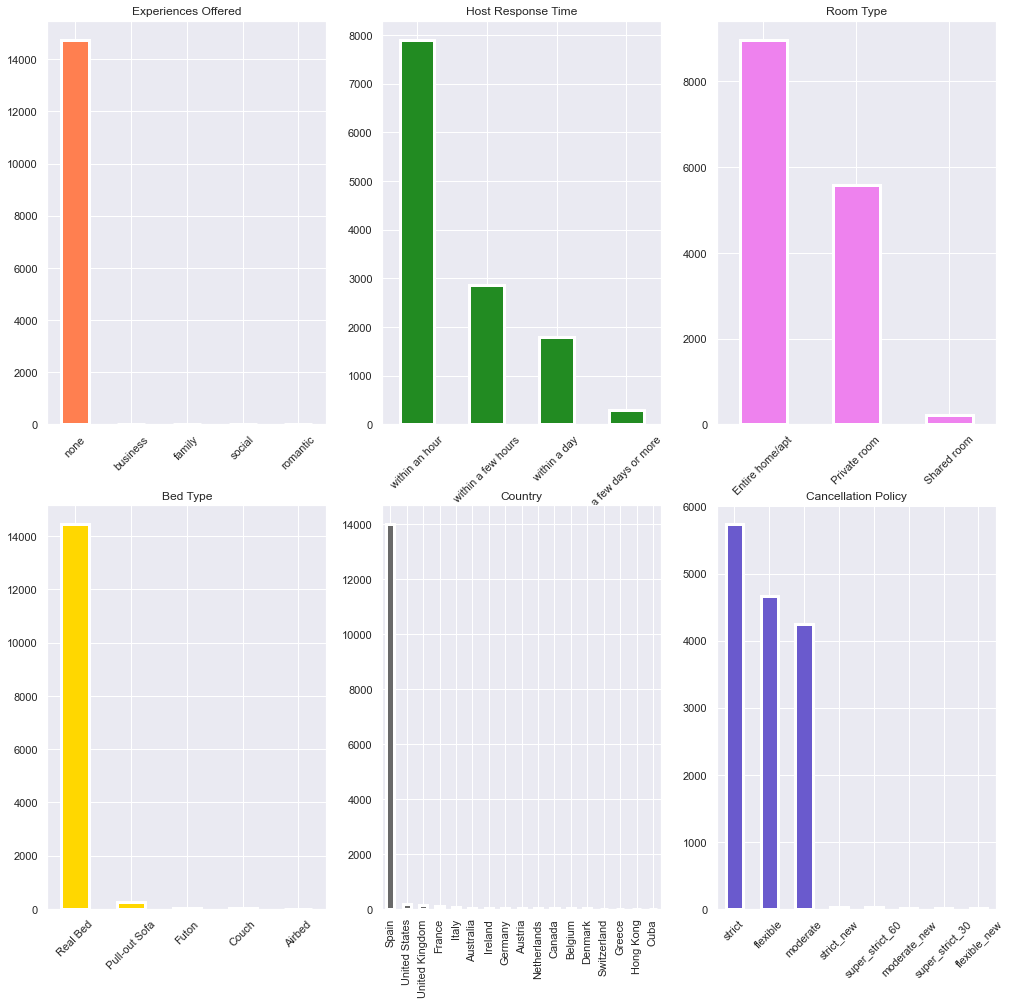

In [25]:
plt.figure(figsize=(17, 52))

plt.subplot(6, 3, 1)
data['Experiences Offered'].value_counts().plot(kind='bar',color = 'coral',linewidth = 3,title='Experiences Offered')
plt.xticks(rotation = 45) 

plt.subplot(6, 3, 2)
data['Host Response Time'].value_counts().plot(kind='bar',color = 'forestgreen',linewidth = 3,title='Host Response Time')
plt.xticks(rotation = 45) 

plt.subplot(6, 3, 3)
data['Room Type'].value_counts().plot(kind='bar',color = 'violet',linewidth = 3,title='Room Type')
plt.xticks(rotation = 45) 

plt.subplot(6, 3, 4)
data['Bed Type'].value_counts().plot(kind='bar',color = 'gold',linewidth = 3,title='Bed Type')
plt.xticks(rotation = 45) 

plt.subplot(6, 3, 5)
data['Country'].value_counts().plot(kind='bar',color = 'dimgray',linewidth = 3,title='Country')

plt.subplot(6, 3, 6)
data['Cancellation Policy'].value_counts().plot(kind='bar',color = 'slateblue',linewidth = 3,title='Cancellation Policy')
plt.xticks(rotation = 45) 

plt.show()

Analizaremos las variables categóricas.

Comenzamos con Experiences Offered:

In [26]:
data['Experiences Offered'].value_counts()

none        14751
business        8
family          3
social          3
romantic        3
Name: Experiences Offered, dtype: int64

La variable Experiences Offered solo tiene 17 valores distintos a none, no tiene ningún sentido trabajar con ella, por lo que la eliminaremos de nuestro conjunto de variables.

In [27]:
data=data.drop(['Experiences Offered'],axis=1)

Bed Type:

In [28]:
data['Bed Type'].value_counts()

Real Bed         14444
Pull-out Sofa      258
Futon               42
Couch               19
Airbed               5
Name: Bed Type, dtype: int64

Transformaremos la variable Bed Type en una dicotómica compuesta por Real Bed y Rest. Habrá que tener cuidado luego al considerar incluirla o no en los modelos por el gran desbalanceo que presenta.

In [29]:
data['Bed Type'] = data['Bed Type'].replace(['Pull-out Sofa','Futon', 'Couch','Airbed'],'Rest')  

<AxesSubplot:title={'center':'Bed Type'}>

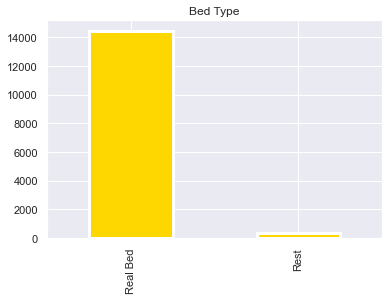

In [30]:
data['Bed Type'].value_counts().plot(kind='bar',color = 'gold',linewidth = 3,title='Bed Type')

Cancellation Policy:

In [31]:
data['Cancellation Policy'].value_counts()

strict             5734
flexible           4669
moderate           4246
strict_new           34
super_strict_60      32
moderate_new         20
super_strict_30      19
flexible_new         14
Name: Cancellation Policy, dtype: int64

Agruparemos las categorías en strict, flexible y moderate para reducir el número de niveles de la variable:

In [32]:
data['Cancellation Policy'] = data['Cancellation Policy'].replace(['strict_new','super_strict_60','super_strict_30'],'strict')  
data['Cancellation Policy'] = data['Cancellation Policy'].replace(['moderate_new'],'moderate')  
data['Cancellation Policy'] = data['Cancellation Policy'].replace(['flexible_new'],'flexible')  

<AxesSubplot:title={'center':'Cancellation Policy'}>

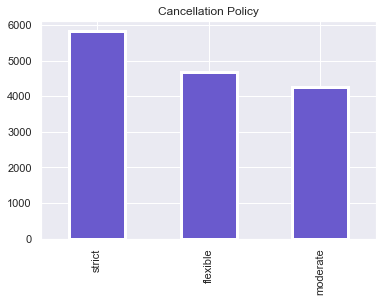

In [33]:
data['Cancellation Policy'].value_counts().plot(kind='bar',color = 'slateblue',linewidth = 3,title='Cancellation Policy')

Para terminar el apartado del análisis descriptivo, representaremos gráficamente la variable objetivo, con el fin de entender mejor su distribución.

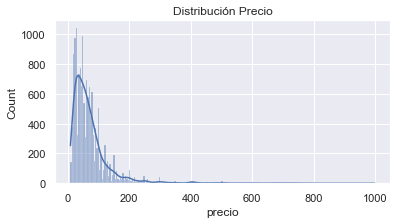

In [220]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sns.histplot(data=data, x='Price', kde=True,ax=ax)
ax.set_title("Distribución Precio")
ax.set_xlabel('precio');

En este caso, la variable precio tiene una distribución asimétrica con una cola positiva debido a que, unos pocos Airbnbs, tienen un precio muy superior a la media.

<AxesSubplot:xlabel='Price'>

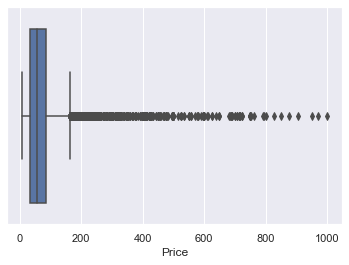

In [35]:
sns.boxplot(x=data['Price'])

In [36]:
data['Price'].describe()

count    14751.000000
mean        73.561792
std         72.065102
min          9.000000
25%         34.000000
50%         55.000000
75%         86.000000
max        999.000000
Name: Price, dtype: float64

Observamos cómo el precio de la estancia para una noche en la mayoría de los alojamientos ronda los 30-90 euros, y este va aumentando hasta encontrarnos con un alojamiento en el que hospedarse un día cuesta hasta 999 euros.

### Correlaciones

Tanto en los histogramas como en los boxplot, se puede observar cómo Host Listings Count y Host Total Listings Count se distribuyen de la misma forma. Vamos a calcular la correlación entre las variables y así aprovecharemos para estudiar la relación entre todas las variables, y en especial entre estas dos.

<AxesSubplot:>

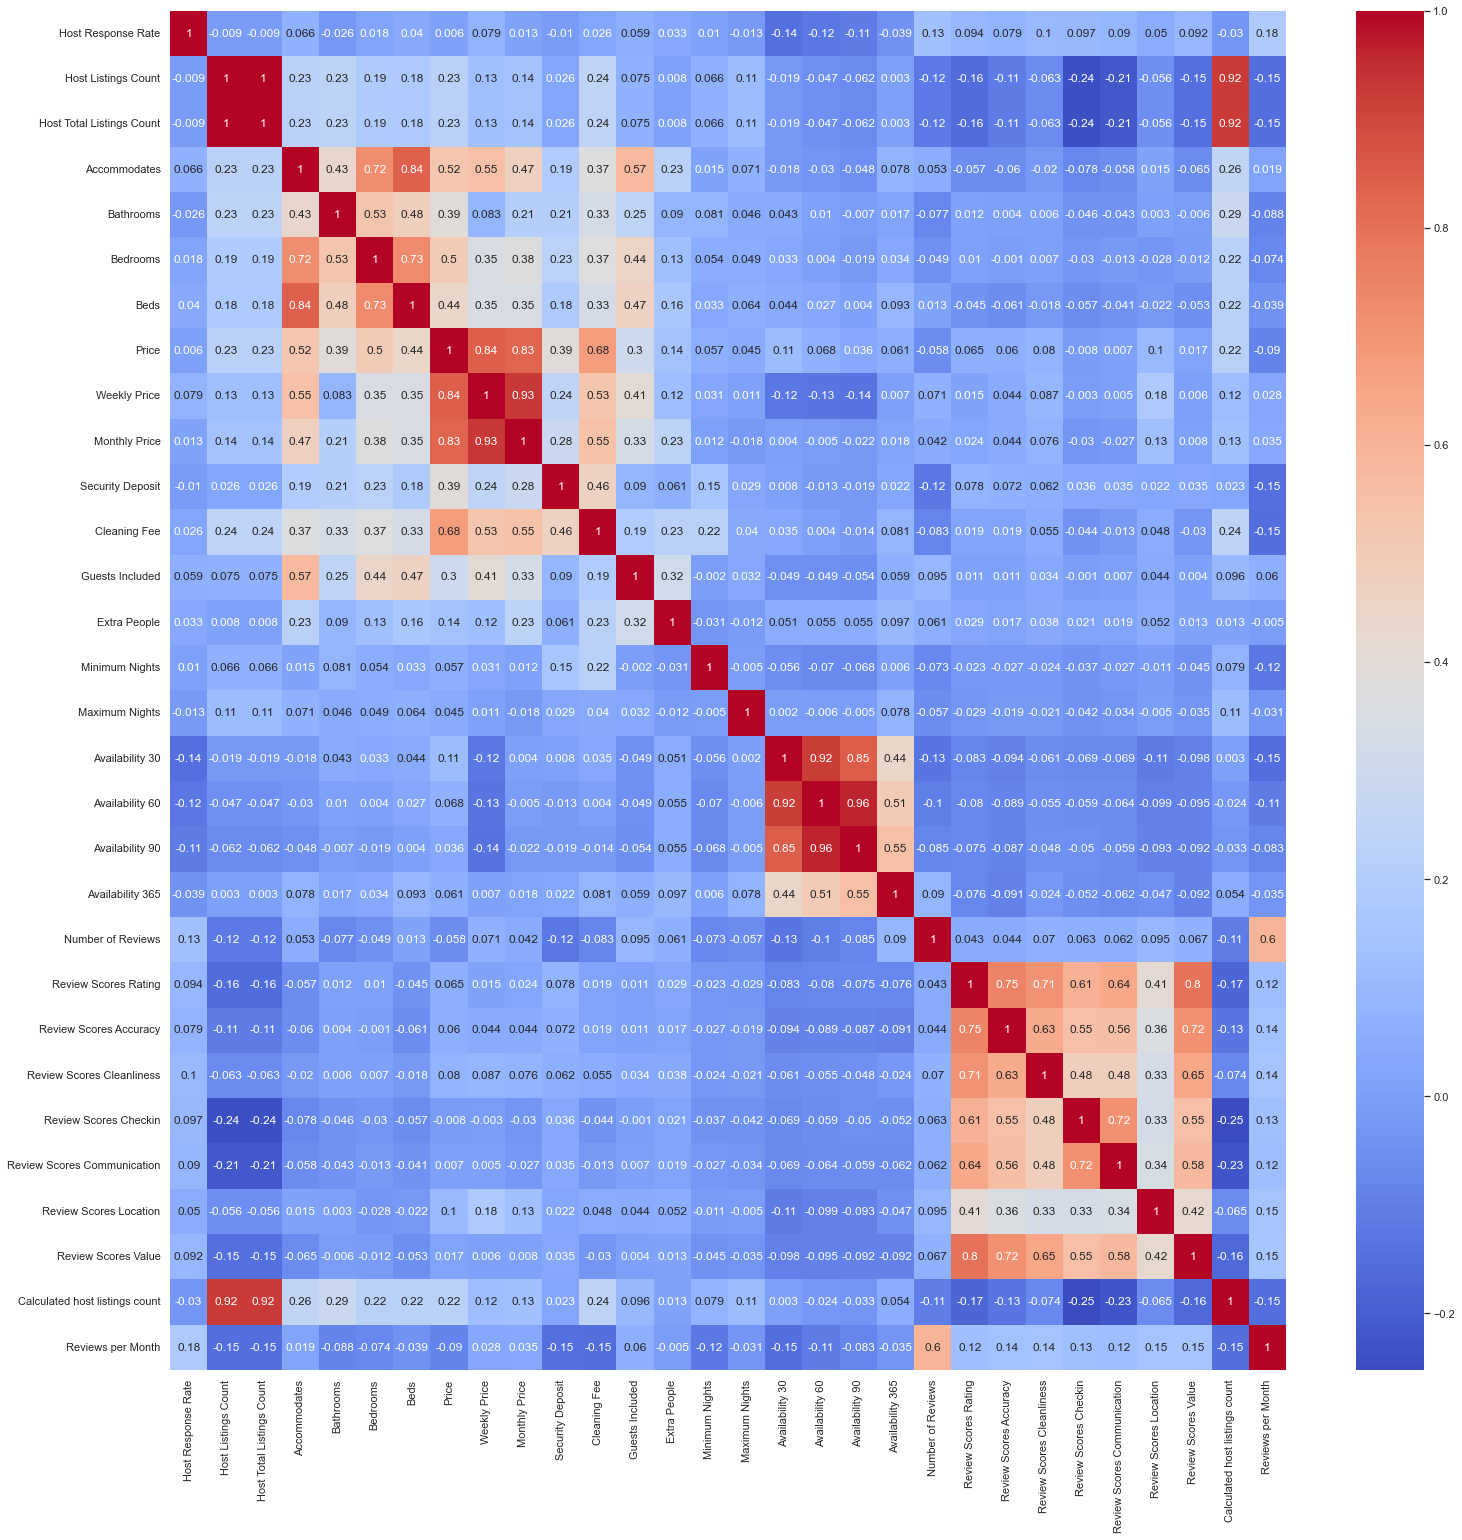

In [37]:
plt.figure(figsize=(25,25))
sns.heatmap(data.corr().round(3),annot=True,cmap='coolwarm')

Efectivamente, podemos observar cómo Host Listings Count y Host Total Listings Count son la misma variable. Además, se pueden observar altas correlaciones entre otros pares de variables, como es el caso de Weekly Price y Monthly Price o de Availability 30, Availability 60 y Availability 90. Tambíen se observa una alta correlación entre Calculated host listings count con Listings Count y Host Total Listings Count.

Eliminamos de nuestro conjunto de datos Host Total Listings Count, Host Listings Count, Availability 60, Weekly Price y Monthly Price y estudiaremos en mayor profundidad el resto de variables con un Scatter plot.

In [38]:
data=data.drop(['Host Total Listings Count','Host Listings Count','Availability 60','Weekly Price','Monthly Price'],axis=1)

Observamos que todas las variables referidas a la Review del alojamiento tienen una alta correlación entre ellas. Vamos a representar el pairplot de este conjunto de variables para comprobar el nivel de relación que presentan y decidir qué hacer con ellas.

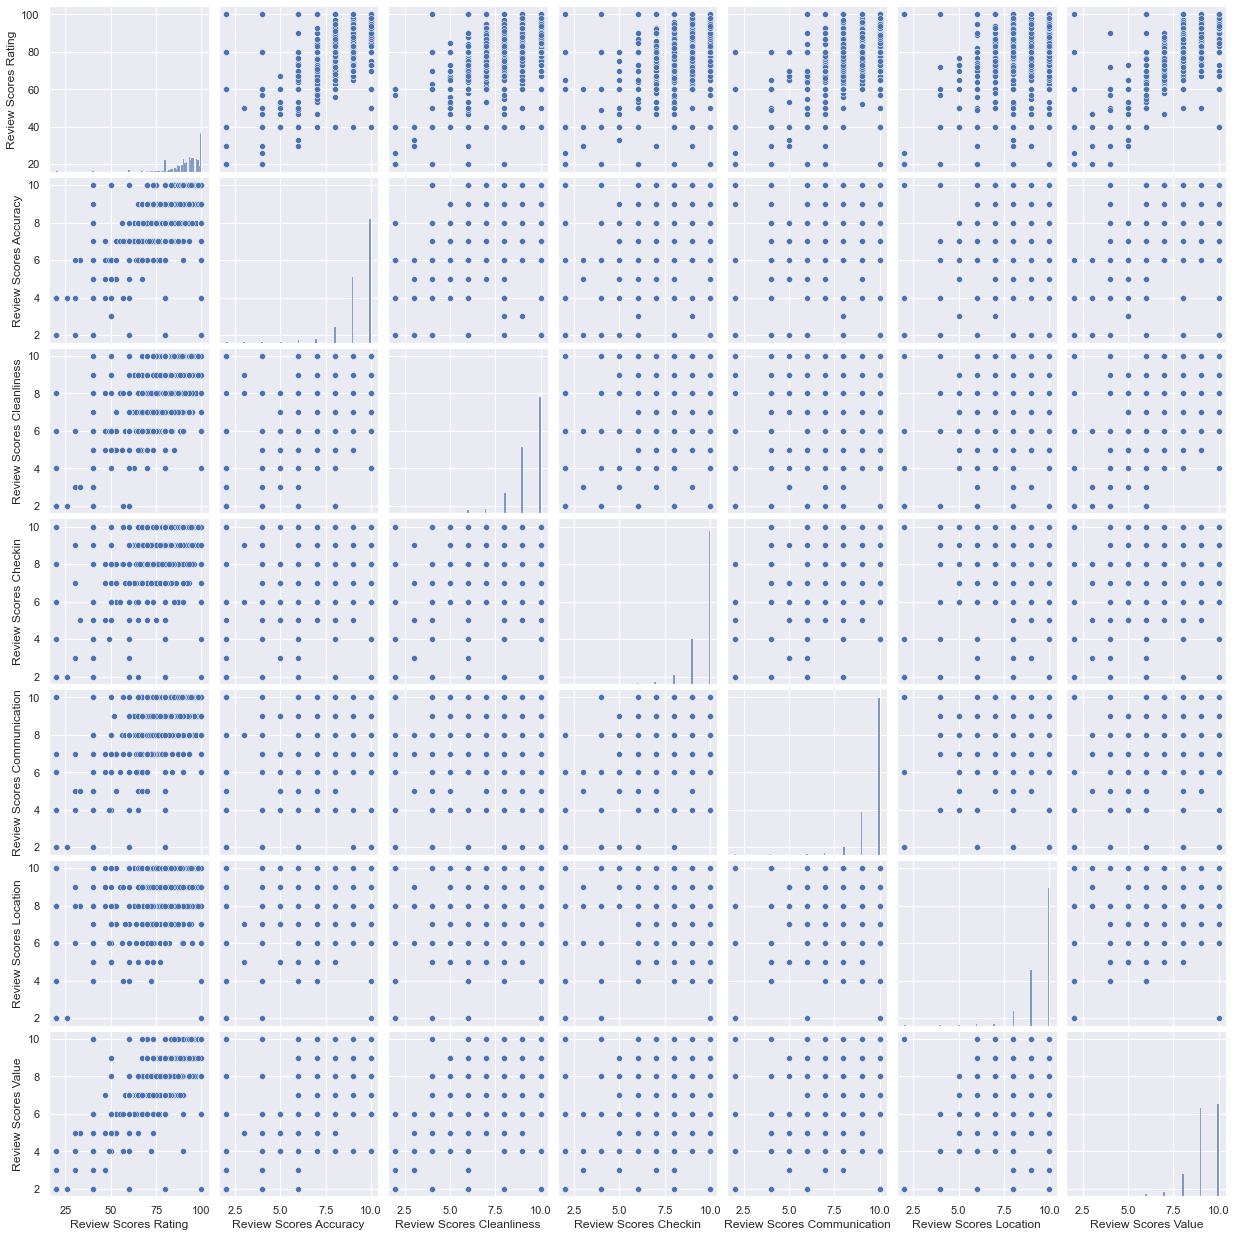

In [39]:
sns.pairplot(data.loc[:,['Review Scores Rating','Review Scores Accuracy','Review Scores Cleanliness',
       'Review Scores Checkin', 'Review Scores Communication',
       'Review Scores Location', 'Review Scores Value']])

Eliminaremos todas las variables referidas a la Review del alojamiento exceptuando Review Scores Rating, que engloba al resto.

In [40]:
data=data.drop(['Review Scores Accuracy','Review Scores Cleanliness',
       'Review Scores Checkin', 'Review Scores Communication',
       'Review Scores Location', 'Review Scores Value'],axis=1)

Representamos el pairplot de las variables Number of Reviews y Reviews per Month, ya que tienen un coeficiente de correlación de 0.6

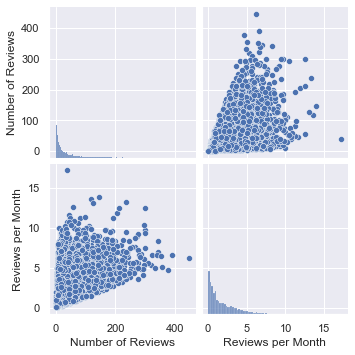

In [41]:
sns.pairplot(data.loc[:,['Number of Reviews','Reviews per Month']])

Observamos una alta homocedasticidad en el gráfico de dispersión de este par de variables, pero no consideramos necesario eliminar ninguna de las dos, pues pueden contener información a la hora de la construcción de los modelos. 

Ahora vamos a representar los gráficos de dispersión del grupo de variables que tienen correlaciones altas con el precio de los alojamientos.

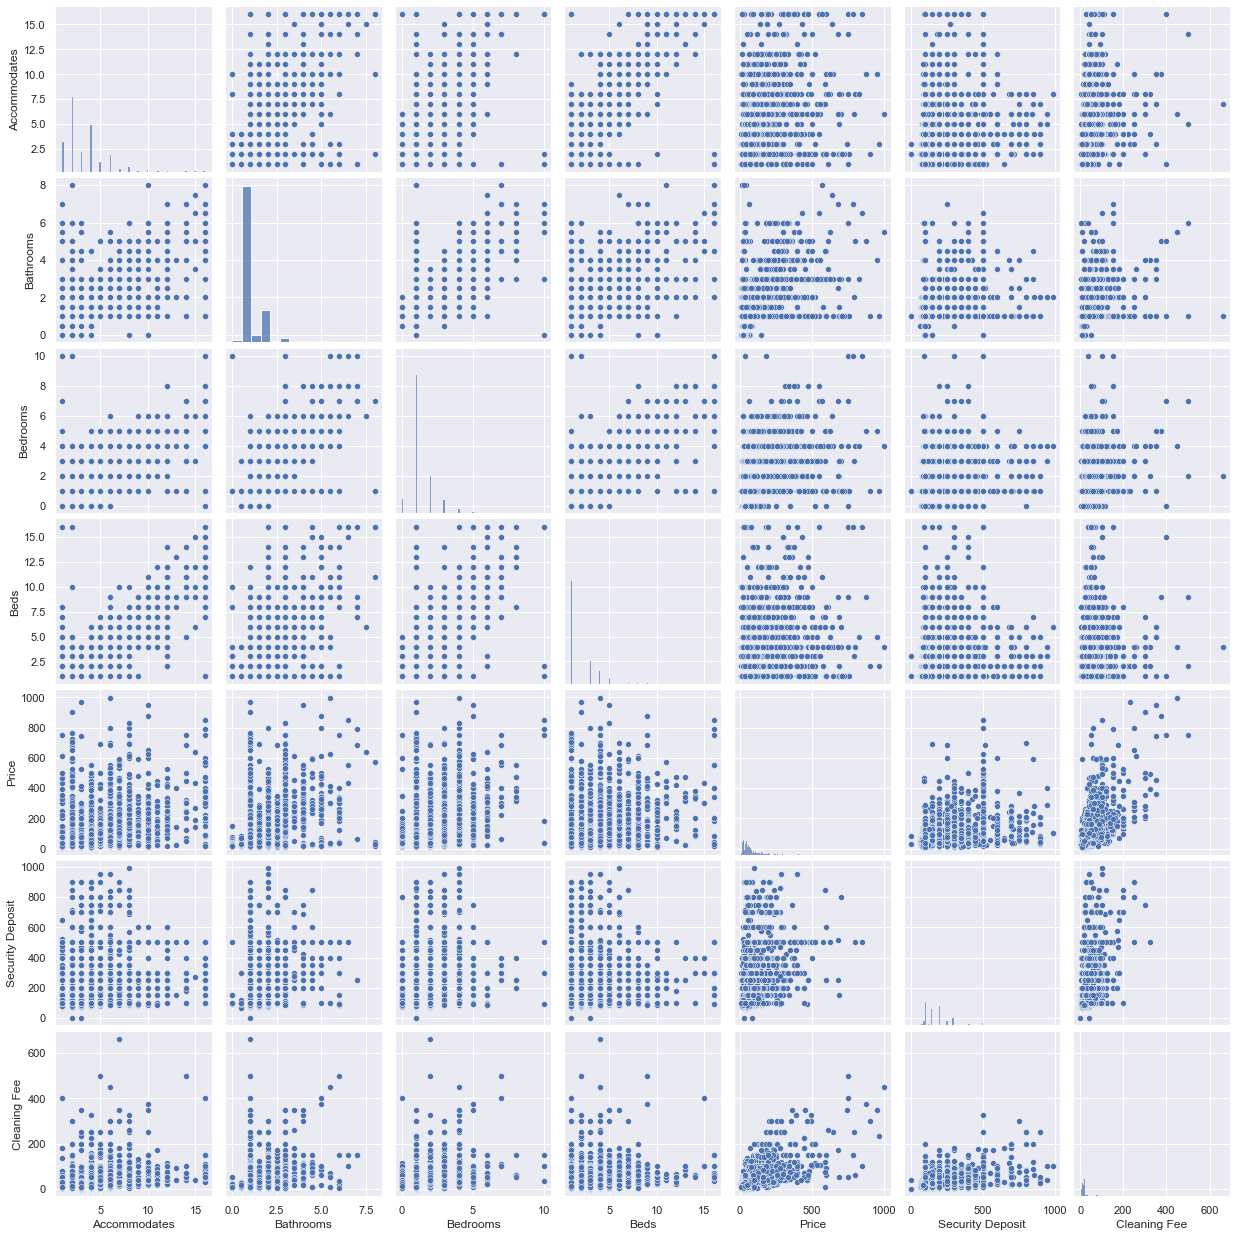

In [42]:
sns.pairplot(data.loc[:,['Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Price', 'Security Deposit', 'Cleaning Fee']])

No se observa ninguna relación muy evidente en los gráficos de dispersión de Price con el resto de variables. Como mucho, una relación creciente con la variable Cleaning Fee, pero el gráfico presenta una homocedasticidad muy alta.

## 2. Transformación de variables e Imputación de missings

En esta sección vamos a ir variable por variable arreglando sus problemas. Es decir, transformaremos las variables object en tipo float o int para que no nos den problemas después y las limpiaremos de missings en el caso de que los tenga.

Hagamos un .info() primero y veamos el estado de nuestras variables.

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14768 entries, 0 to 14779
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      14765 non-null  object 
 1   Host Response Time              12874 non-null  object 
 2   Host Response Rate              12874 non-null  float64
 3   Host Verifications              14762 non-null  object 
 4   City                            14762 non-null  object 
 5   Country                         14767 non-null  object 
 6   Property Type                   14768 non-null  object 
 7   Room Type                       14768 non-null  object 
 8   Accommodates                    14768 non-null  int64  
 9   Bathrooms                       14713 non-null  float64
 10  Bedrooms                        14743 non-null  float64
 11  Beds                            14719 non-null  float64
 12  Bed Type                        

Observemos que tenemos muchas variables tipo object. Esto nos va a dar problemas a la hora de imputar missings o al realizar algunos modelos. Debemos arreglar esto e imputar esos datos faltantes cuando sea necesario. Vayamos una por una.

#### Host since
Observemos cómo es la variable.

In [44]:
data['Host Since']

0        2016-02-11
1        2016-11-08
2        2016-11-08
3        2010-05-25
4        2016-01-12
            ...    
14775    2013-12-18
14776    2017-03-24
14777    2015-07-06
14778    2013-03-20
14779    2014-04-21
Name: Host Since, Length: 14768, dtype: object

Parece que es una variable tipo fecha, una buena idea para transformarla en float es restarsela al día actual de hoy que, gracias a python, podemos tener siempre actualizada. De esta manera obtendremos el número de días que lleva el anfitrión ofertando su propiedad en Airbnb. Los tres missings que tiene nos van a dar problemas, por lo que los vamos a eliminar pues sólo son 3.

In [45]:
data = data.dropna(subset=['Host Since'])

In [46]:
data['Host Since'].isna().sum()

0

Escribimos la función planteada anteriormente y comprobamos que funciona.

In [47]:
from datetime import date
today = date.today()
for i in data['Host Since']:
    if isinstance(i, str):
        days = (today - date.fromisoformat(i)).days
        data['Host Since'] = data['Host Since'].replace(i,days) 

In [48]:
data['Host Since']

0        2296
1        2025
2        2025
3        4384
4        2326
         ... 
14775    3081
14776    1889
14777    2516
14778    3354
14779    2957
Name: Host Since, Length: 14765, dtype: int64

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14765 entries, 0 to 14779
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      14765 non-null  int64  
 1   Host Response Time              12874 non-null  object 
 2   Host Response Rate              12874 non-null  float64
 3   Host Verifications              14759 non-null  object 
 4   City                            14759 non-null  object 
 5   Country                         14764 non-null  object 
 6   Property Type                   14765 non-null  object 
 7   Room Type                       14765 non-null  object 
 8   Accommodates                    14765 non-null  int64  
 9   Bathrooms                       14710 non-null  float64
 10  Bedrooms                        14740 non-null  float64
 11  Beds                            14716 non-null  float64
 12  Bed Type                        

#### Host Response Time y Host Response Rate

Observemos primero que Host Response Time es de tipo object, transformemosla en tipo int

In [50]:
data['Host Response Time']

0            within an hour
1            within an hour
2            within an hour
3            within an hour
4            within an hour
                ...        
14775    within a few hours
14776                   NaN
14777        within an hour
14778    within a few hours
14779        within an hour
Name: Host Response Time, Length: 14765, dtype: object

<AxesSubplot:title={'center':'Host Response Time'}>

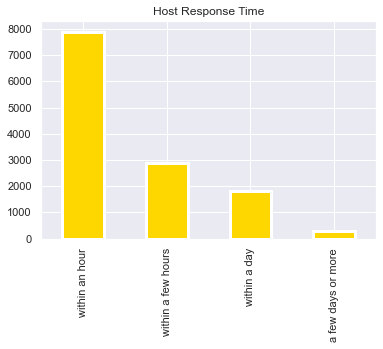

In [51]:
data['Host Response Time'].value_counts().plot(kind='bar',color = 'gold',linewidth = 3,title='Host Response Time')

Para que se asemeje a Host Response Rate, llamaremos a few days or more como 0 e iremos aumentando hasta 3.

In [52]:
data['Host Response Time'] = data['Host Response Time'].replace(['a few days or more'],0) 
data['Host Response Time'] = data['Host Response Time'].replace(['within a day'],1) 
data['Host Response Time'] = data['Host Response Time'].replace(['within a few hours'],2) 
data['Host Response Time'] = data['Host Response Time'].replace(['within an hour'],3) 

In [53]:
data['Host Response Time']

0        3.0
1        3.0
2        3.0
3        3.0
4        3.0
        ... 
14775    2.0
14776    NaN
14777    3.0
14778    2.0
14779    3.0
Name: Host Response Time, Length: 14765, dtype: float64

Antes de imputar los missings observemos dos cosas:
   1. Que si la observación tiene un Host response Rate de 0, entonces tiene un Host Response Time también de 0. Es decir, que la gente que no contesta nunca (Host Response Rate = 0) se mete en el grupo de a few days or more en Host response Time.
   2. Que ambas variables tienen los mismos valores missings y, de hecho, coinciden.

In [54]:
data[data['Host Response Rate']==0]

Host Since  Host Response Time  Host Response Rate  \
69           4382                 0.0                 0.0   
82           3143                 0.0                 0.0   
168          2776                 0.0                 0.0   
183          2540                 0.0                 0.0   
189          3633                 0.0                 0.0   
...           ...                 ...                 ...   
14242        2249                 0.0                 0.0   
14265        3474                 0.0                 0.0   
14588        2320                 0.0                 0.0   
14634        2639                 0.0                 0.0   
14662        2419                 0.0                 0.0   

                             Host Verifications    City Country  \
69           email,phone,facebook,reviews,jumio  Madrid   Spain   
82     email,phone,reviews,manual_offline,jumio  Madrid   Spain   
168    email,phone,reviews,manual_offline,jumio  Madrid   Spain   
183                   email,phone,reviews,jumio  Madrid   Spain   
189                         email,phone,reviews  Madrid   Spain   
...                                         ...     ...     ...   
14242                               email,phone  Madrid   Spain   
14265              email,phone,facebook,reviews  Madrid   Spain   
14588                             phone,reviews  Madrid   Spain   
14634                       email,phone,reviews  Madrid   Spain   
14662          email,phone,google,reviews,jumio  Madrid   Spain   

         Property Type        Room Type  Accommodates  Bathrooms  ...  \
69           Apartment     Private room             1        2.0  ...   
82           Apartment  Entire home/apt             8        1.0  ...   
168          Apartment  Entire home/apt             4        2.0  ...   
183          Apartment     Private room             1        1.0  ...   
189          Apartment     Private room             1        1.5  ...   
...                ...              ...           ...        ...  ...   
14242  Bed & Breakfast     Private room             2        1.0  ...   
14265        Apartment  Entire home/apt             4        1.0  ...   
14588        Apartment     Private room             1        1.0  ...   
14634        Apartment      Shared room             1        1.0  ...   
14662            House     Private room             1        1.0  ...   

       Maximum Nights  Calendar Updated Availability 30 Availability 90  \
69               1125      2 months ago               0               6   
82               1125             today               0               0   
168              1125       3 weeks ago               2              52   
183                30      2 months ago              28              88   
189              1125        2 days ago               0               7   
...               ...               ...             ...             ...   
14242            1125      2 months ago              30              90   
14265            1125      3 months ago               0               3   
14588            1125      4 months ago              30              90   
14634            1125     25 months ago              30              90   
14662            1125      5 months ago              30              90   

       Availability 365  Number of Reviews  Review Scores Rating  \
69                  281                  0                   NaN   
82                   82                  1                  40.0   
168                 304                 17                  83.0   
183                 178                  3                 100.0   
189                 130                  7                  93.0   
...                 ...                ...                   ...   
14242               365                  0                   NaN   
14265               278                  3                  50.0   
14588               365                  8                  93.0   
14634      

In [55]:
data['Host Response Time'].isna().sum()==data['Host Response Rate'].isna().sum()

True

In [56]:
data[data['Host Response Rate'].isna()]

Host Since  Host Response Time  Host Response Rate  \
11           3081                 NaN                 NaN   
22           2165                 NaN                 NaN   
34           2982                 NaN                 NaN   
36           2944                 NaN                 NaN   
38           3276                 NaN                 NaN   
...           ...                 ...                 ...   
14743        2142                 NaN                 NaN   
14760        3129                 NaN                 NaN   
14762        3166                 NaN                 NaN   
14774        4002                 NaN                 NaN   
14776        1889                 NaN                 NaN   

                         Host Verifications         City        Country  \
11     email,phone,reviews,jumio,work_email    Antwerpen        Belgium   
22                      email,phone,reviews    Barcelona          Spain   
34                        email,phone,jumio    Barcelona          Spain   
36                        email,phone,jumio    Amsterdam    Netherlands   
38                email,phone,reviews,jumio        Paris         France   
...                                     ...          ...            ...   
14743                                 phone       Madrid          Spain   
14760             email,phone,reviews,jumio  Los Angeles  United States   
14762                   email,phone,reviews     Pollença          Spain   
14774      email,phone,facebook,reviews,kba       Queens  United States   
14776                           email,phone        Paris         France   

         Property Type        Room Type  Accommodates  Bathrooms  ...  \
11           Apartment  Entire home/apt             2        1.0  ...   
22           Apartment  Entire home/apt             4        2.0  ...   
34           Apartment  Entire home/apt             1        1.0  ...   
36           Apartment     Private room             2        1.0  ...   
38           Apartment  Entire home/apt             6        1.0  ...   
...                ...              ...           ...        ...  ...   
14743        Apartment     Private room             1        2.0  ...   
14760        Apartment  Entire home/apt             3        1.0  ...   
14762        Apartment  Entire home/apt             6        1.0  ...   
14774        Apartment     Private room             1        1.0  ...   
14776  Bed & Breakfast     Private room             1        1.0  ...   

       Maximum Nights  Calendar Updated Availability 30 Availability 90  \
11               1125      7 months ago               0              33   
22               1125      8 months ago               0               0   
34               1125      2 months ago              30              90   
36               1125     13 months ago               0               0   
38               1125      7 months ago               0               0   
...               ...               ...             ...             ...   
14743            1125      7 months ago               0               7   
14760            1125      6 months ago               0               0   
14762            1125       4 weeks ago              16              16   
14774              68     11 months ago               0               0   
14776               7        3 days ago              17              77   

       Availability 365  Number of Reviews  Review Scores Rating  \
11                  308                  7                  97.0   
22                    0                  1                 100.0   
34                   90                  1                   NaN   
36                    0                  0                   NaN   
38                    0                  8                  93.0   
...                 ...                ...                   ...   
14743               282                  0                   NaN   
14760                 0                  3         

No vamos a eliminar las observaciones con missings del dataset pues todo apunta a que estos missings tienen significado. El significado que le damos es que el propietario del airbnb no ha contestado nunca aún. Podríamos crear una nueva variable en Host Response Time que refleje esto. Pero como hemos visto que la gente que no responde prácticamente nuca (Host Response Rate = 0) se introduce en el grupo de a few days or more en Host Response Time creemos más conveniente imputar los missings por 0 en Host Response Time y, por tanto, meterlos en el grupo de a few days or more (0).

In [57]:
data.fillna({'Host Response Time': 0}, inplace=True)
data.fillna({'Host Response Rate': 0}, inplace=True)

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14765 entries, 0 to 14779
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      14765 non-null  int64  
 1   Host Response Time              14765 non-null  float64
 2   Host Response Rate              14765 non-null  float64
 3   Host Verifications              14759 non-null  object 
 4   City                            14759 non-null  object 
 5   Country                         14764 non-null  object 
 6   Property Type                   14765 non-null  object 
 7   Room Type                       14765 non-null  object 
 8   Accommodates                    14765 non-null  int64  
 9   Bathrooms                       14710 non-null  float64
 10  Bedrooms                        14740 non-null  float64
 11  Beds                            14716 non-null  float64
 12  Bed Type                        

Poco a poco esto ya va teniendo mejor pinta, sigamos.

#### Host Verifications

Observemos antes de hacer nada que los nulos de Host Verifications pueden tener significado. Que no tengan ninguna verificación. Fijémonos que todos los datos están formados por una cadena de caracteres que no está vacía. Es muy probable que si está vacía airbnb la haya categorizado como un valor faltante. Así estos 6 nulos en Host Verification es importante no eliminarlos aunque sean pocos.

In [59]:
list(data['Host Verifications'].head(10))

['email,phone,reviews,kba',
 'email,phone,reviews,work_email',
 'email,phone,reviews,work_email',
 'email,phone,facebook,reviews,manual_offline,jumio,work_email',
 'email,phone,reviews,jumio',
 'email,phone,reviews,jumio',
 'email,phone,reviews',
 'email,phone,facebook,reviews',
 'email,phone,reviews,jumio',
 'email,phone,reviews,kba']

Se nos ocurre hacer una cosa para transformar estas cadenas de caracteres en tipo int. Observamos que podemos recoger la misma información de esta variable si contáramos la cantidad de medios que ofrece el propietario para contactar con él. Podemos separar astutamente las observaciones con split y contarlas. De esta manera conseguimos nuestro objetivo.

In [60]:
# Un ejemplo
ejemplo = data['Host Verifications'][0].split(sep=',')
print ('El propietario es contactable mediante ', ejemplo, 'tiene ', len(ejemplo), 'formas disponibles de contactar con él')

El propietario es contactable mediante  ['email', 'phone', 'reviews', 'kba'] tiene  4 formas disponibles de contactar con él


Bien, funciona. Hagamos esto para todas las observaciones dándole el valor 0 a los missings que encontremos.

In [61]:
data.fillna({'Host Verifications': 0}, inplace=True)
for i in data['Host Verifications']:
    if isinstance(i, str):
        data['Host Verifications'] = data['Host Verifications'].replace(i,len(i.split(sep=','))) 

In [62]:
data['Host Verifications']

0        4
1        4
2        4
3        7
4        4
        ..
14775    4
14776    2
14777    4
14778    6
14779    7
Name: Host Verifications, Length: 14765, dtype: int64

#### City, Country, Property Type, Room Type y Bed Type

Para imputar el único missing de Country basta buscar cual es y añadir en country su valor correcto.

In [63]:
data[data['Country'].isna()]

Host Since  Host Response Time  Host Response Rate  Host Verifications  \
151        3202                 0.0                 0.0                   2   

        City Country Property Type     Room Type  Accommodates  Bathrooms  \
151  Salerno     NaN         House  Private room             1        1.0   

     ...  Maximum Nights  Calendar Updated Availability 30 Availability 90  \
151  ...            1125     31 months ago              30              90   

     Availability 365  Number of Reviews  Review Scores Rating  \
151               365                  0                   NaN   

     Cancellation Policy  Calculated host listings count  Reviews per Month  
151             flexible                             1.0                NaN  

[1 rows x 30 columns]

Sabemos que Salerno está en Italia, imputémoslo

In [64]:
data.loc[151,'Country']='Italy'

City es más complejo, pues todos los apartamentos con missings, están en España. Podríamos imputar por la moda de los que están en España pero podemos cometer errores porque nada nos dice que acertemos al hacer eso. Como sólo son 6 observaciones, creemos que lo más correcto es eliminarlas y evitar así problemas.

In [65]:
data = data.dropna(subset=['City'])

In [66]:
data.isna().sum()

Host Since                           0
Host Response Time                   0
Host Response Rate                   0
Host Verifications                   0
City                                 0
Country                              0
Property Type                        0
Room Type                            0
Accommodates                         0
Bathrooms                           55
Bedrooms                            25
Beds                                49
Bed Type                             0
Amenities                          165
Price                               17
Security Deposit                  8509
Cleaning Fee                      6082
Guests Included                      0
Extra People                         0
Minimum Nights                       0
Maximum Nights                       0
Calendar Updated                     0
Availability 30                      0
Availability 90                      0
Availability 365                     0
Number of Reviews        

Ya están limpias de datos faltantes, pero siguen siendo tipo object. Utilizaremos Label Encoder para transformarlas.

In [67]:
from sklearn.preprocessing import LabelEncoder

LE=LabelEncoder()
for i in data.iloc[:,[4,5,6,7,12]]:
    data[i]=data[[i]].apply(LE.fit_transform)

In [68]:
data.head(10)

Host Since  Host Response Time  Host Response Rate  Host Verifications  \
0        2296                 3.0               100.0                   4   
1        2025                 3.0               100.0                   4   
2        2025                 3.0               100.0                   4   
3        4384                 3.0               100.0                   7   
4        2326                 3.0                99.0                   4   
5        2326                 3.0                99.0                   4   
6        3260                 1.0               100.0                   3   
7        3612                 3.0               100.0                   4   
8        2326                 3.0                99.0                   4   
9        2607                 2.0               100.0                   4   

   City  Country  Property Type  Room Type  Accommodates  Bathrooms  ...  \
0    13       16             15          0             2        1.0  ...   
1    16       13              0          0             4        1.0  ...   
2    16       13              0          0             4        1.0  ...   
3    16       13              0          0             8        2.0  ...   
4    16       13              0          0             5        1.0  ...   
5    16       13              0          0             6        1.0  ...   
6    16       13              0          0             5        2.0  ...   
7    16       13              0          1             2        1.0  ...   
8    16       13              0          0             6        2.0  ...   
9    13       16             14          0             6        2.0  ...   

   Maximum Nights  Calendar Updated  Availability 30 Availability 90  \
0            1125             today               10              64   
1            1125             today                6              39   
2            1125             today                7              42   
3            1125             today               11              47   
4            1125             today                0               0   
5            1125       2 weeks ago                0               2   
6             365             today                4              23   
7               7         yesterday               13              66   
8            1125        a week ago                0               2   
9            1125             today               21              81   

   Availability 365  Number of Reviews  Review Scores Rating  \
0               281                 42                  98.0   
1               309                  1                  80.0   
2               291                  0                   NaN   
3               316                 13                  92.0   
4                 7                  0                   NaN   
5                 4                  0                   NaN   
6               280                 43                  90.0   
7                66                 29                  96.0   
8                 2                  1                  80.0   
9               356                  1                 100.0   

   Cancellation Policy  Calculated host listings count  Reviews per Month  
0             moderate                             1.0               3.50  
1               strict                           106.0               0.86  
2               strict                           106.0                NaN  
3               strict                            24.0               1.09  
4             flexible                            92.0                NaN  
5               strict                            92.0                NaN  
6               strict                             1.0               1.22  
7             flexible                             1.0               0.64  
8               strict                            92.0               0.33  
9               strict                             1.0      

#### Bathrooms, Bedrooms y Beds

Estas variables ya son de tipo float, así que genial, pero contienen missings. Podríamos haber pensado que esos missings significa que el apartamento no tiene alguna de esas cosas pero podemos comprobar que existen muchos apartamentos a los que les ocurre eso.

In [69]:
(data.Bedrooms==0).sum()+(data.Bathrooms==0).sum()+(data.Beds==0).sum()

1067

Por lo que al ser tan pocos missings es probable que simplemente haya habido un error al recoger esa información en la base de datos. Utilizaremos KNNimputer para darles un buen valor. Escogeremos como vecinos el 0'001% de las observaciones totales, es decir, 15 vecinos. Y  redondearemos los resultados a las unidades pues los valores reales son números enteros. Podríamos haber imputado todos por la mediana, pero es más interesante y elegante así. Además, respetamos mejor la forma de la distribución de los datos. La otra forma de imputación podía provocar leptocurtez.

In [70]:
knn = KNNImputer(n_neighbors=15)
data["Bathrooms"] = np.around(knn.fit_transform(data["Bathrooms"].values.reshape(-1, 1)),decimals=0)
data["Bedrooms"] = np.around(knn.fit_transform(data["Bedrooms"].values.reshape(-1, 1)),decimals=0)
data["Beds"] = np.around(knn.fit_transform(data["Beds"].values.reshape(-1, 1)),decimals=0)

In [71]:
data.isna().sum()

Host Since                           0
Host Response Time                   0
Host Response Rate                   0
Host Verifications                   0
City                                 0
Country                              0
Property Type                        0
Room Type                            0
Accommodates                         0
Bathrooms                            0
Bedrooms                             0
Beds                                 0
Bed Type                             0
Amenities                          165
Price                               17
Security Deposit                  8509
Cleaning Fee                      6082
Guests Included                      0
Extra People                         0
Minimum Nights                       0
Maximum Nights                       0
Calendar Updated                     0
Availability 30                      0
Availability 90                      0
Availability 365                     0
Number of Reviews        

#### Amenities

Con amenities volvemos a tener el mismo problema que se nos presentó al hacer Host Verifications. Los elementos son strings y cuantas más amenities (comodidades) haya, mucho mejor. Lo resolveremos de la misma forma. Además, hay 165 missings que reflejan que el apartamento presenta una lista vacía de comodidades, por lo que esos los imputaremos por 0.

In [72]:
data['Amenities']

0        TV,Cable TV,Internet,Wireless Internet,Air con...
1        Wireless Internet,Air conditioning,Elevator in...
2        Wireless Internet,Air conditioning,Elevator in...
3        TV,Internet,Wireless Internet,Air conditioning...
4        TV,Wireless Internet,Air conditioning,Kitchen,...
                               ...                        
14775    TV,Cable TV,Internet,Wireless Internet,Air con...
14776    TV,Wireless Internet,Kitchen,Breakfast,Elevato...
14777    TV,Cable TV,Internet,Wireless Internet,Air con...
14778    Internet,Wireless Internet,Kitchen,Heating,Was...
14779    TV,Cable TV,Internet,Wireless Internet,Air Con...
Name: Amenities, Length: 14759, dtype: object

In [73]:
data.fillna({'Amenities': 0}, inplace=True)
for i in data['Amenities']:
    if isinstance(i, str):
        data['Amenities'] = data['Amenities'].replace(i,len(i.split(sep=',')))

In [74]:
data['Amenities']

0        23
1         7
2         7
3        24
4        12
         ..
14775    11
14776    11
14777    17
14778    18
14779    21
Name: Amenities, Length: 14759, dtype: int64

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14759 entries, 0 to 14779
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      14759 non-null  int64  
 1   Host Response Time              14759 non-null  float64
 2   Host Response Rate              14759 non-null  float64
 3   Host Verifications              14759 non-null  int64  
 4   City                            14759 non-null  int32  
 5   Country                         14759 non-null  int32  
 6   Property Type                   14759 non-null  int32  
 7   Room Type                       14759 non-null  int32  
 8   Accommodates                    14759 non-null  int64  
 9   Bathrooms                       14759 non-null  float64
 10  Bedrooms                        14759 non-null  float64
 11  Beds                            14759 non-null  float64
 12  Bed Type                        

#### Price

Price es nuestra variable objetivo. Por lo tanto no nos interesa imputar missings aquí, puede llevar a errores en el modelo. Además sólo hay 17, vamos a eliminarlos.

In [76]:
data = data.dropna(subset=['Price'])

In [77]:
data.isna().sum()

Host Since                           0
Host Response Time                   0
Host Response Rate                   0
Host Verifications                   0
City                                 0
Country                              0
Property Type                        0
Room Type                            0
Accommodates                         0
Bathrooms                            0
Bedrooms                             0
Beds                                 0
Bed Type                             0
Amenities                            0
Price                                0
Security Deposit                  8494
Cleaning Fee                      6074
Guests Included                      0
Extra People                         0
Minimum Nights                       0
Maximum Nights                       0
Calendar Updated                     0
Availability 30                      0
Availability 90                      0
Availability 365                     0
Number of Reviews        

#### Security Deposit y Cleaning Fee

Viendo la elevada cantidad de missings que hay y la estructura de los datos es claro que los missings de estas variables tienen significado, que es, básicamente que el depósito de seguridad y la tarifa de limpieza son 0. Imputémoslo por eso entonces.

In [78]:
data.fillna({'Security Deposit': 0}, inplace=True)
data.fillna({'Cleaning Fee': 0}, inplace=True)

In [79]:
data.isna().sum()

Host Since                           0
Host Response Time                   0
Host Response Rate                   0
Host Verifications                   0
City                                 0
Country                              0
Property Type                        0
Room Type                            0
Accommodates                         0
Bathrooms                            0
Bedrooms                             0
Beds                                 0
Bed Type                             0
Amenities                            0
Price                                0
Security Deposit                     0
Cleaning Fee                         0
Guests Included                      0
Extra People                         0
Minimum Nights                       0
Maximum Nights                       0
Calendar Updated                     0
Availability 30                      0
Availability 90                      0
Availability 365                     0
Number of Reviews        

#### Calendar Updated

¿Podríamos eliminar esta variable por el trabajo que nos va a llevar transformarla a int? Sí, sin ninguna duda. Sería sorprendente que fuera mínimamemte importante en los modelos. Pero una vez mi padre me dijo que la diferencia entre un 10 y un 9 estaba en los detalles. Y nosottros vamos a por el 10.

Dicho esto, para transformar esta variable de object a int y que mantenga su significado, vamos a crear un código que coja el string que refleja hace cuánto se actualizó el calendario y te devuelve el número de días desde que se actualizó.

In [80]:
data['Calendar Updated'].head(20)

0            today
1            today
2            today
3            today
4            today
5      2 weeks ago
6            today
7        yesterday
8       a week ago
9            today
10      a week ago
11    7 months ago
12           today
13     2 weeks ago
14     4 weeks ago
15           today
16      a week ago
17     5 weeks ago
18           today
19      a week ago
Name: Calendar Updated, dtype: object

In [81]:
for i in data['Calendar Updated']:
    if isinstance(i, str):
        if i.split()[0] == 'today':
            data['Calendar Updated'] = data['Calendar Updated'].replace(i,0)
        elif i.split()[0] == 'yesterday':
            data['Calendar Updated'] = data['Calendar Updated'].replace(i,1)
        elif i.split()[0] == 'never':
            data['Calendar Updated'] = data['Calendar Updated'].replace(i,2000) # EL máximo son 58 meses (1740 días aprox), si vemos uno con 2000 días, sabremos que es never
        elif i.split()[1] == 'days':
            data['Calendar Updated'] = data['Calendar Updated'].replace(i,int(i.split()[0]))
        elif i.split()[1] == 'week':
            data['Calendar Updated'] = data['Calendar Updated'].replace(i,7)
        elif i.split()[1] == 'weeks':
            data['Calendar Updated'] = data['Calendar Updated'].replace(i,int(i.split()[0])*7)
        else:
            data['Calendar Updated'] = data['Calendar Updated'].replace(i,int(i.split()[0])*30)

Comprobamos que funciona

In [82]:
data['Calendar Updated'].head(20)

0       0
1       0
2       0
3       0
4       0
5      14
6       0
7       1
8       7
9       0
10      7
11    210
12      0
13     14
14     28
15      0
16      7
17     35
18      0
19      7
Name: Calendar Updated, dtype: int64

#### Review Scores Rating y Reviews Per Month

Estas variable ya están en tipo float así que eso que nos ahorramos, pero debemos imputar sus missings.

In [83]:
data[data['Review Scores Rating'].isna()].T

2         4       5       12        20     \
Host Since                        2025      2326    2326    2025      2667   
Host Response Time                 3.0       3.0     3.0     3.0       2.0   
Host Response Rate               100.0      99.0    99.0   100.0     100.0   
Host Verifications                   4         4       4       4         4   
City                                16        16      16      16        16   
Country                             13        13      13      13        13   
Property Type                        0         0       0       0         0   
Room Type                            0         0       0       0         1   
Accommodates                         4         5       6       4         2   
Bathrooms                          1.0       1.0     1.0     1.0       2.0   
Bedrooms                           1.0       2.0     2.0     1.0       1.0   
Beds                               1.0       2.0     3.0     1.0       1.0   
Bed Type                             0         0       0       0         0   
Amenities                            7        12       9       8        18   
Price                             70.0     149.0   106.0    90.0      40.0   
Security Deposit                 200.0       0.0     0.0   300.0       0.0   
Cleaning Fee                      60.0      55.0     0.0    60.0       5.0   
Guests Included                      2         1       1       2         1   
Extra People                        42         0       0      42        15   
Minimum Nights                       1         2       2       1         1   
Maximum Nights                    1125      1125    1125    1125      1125   
Calendar Updated                     0         0      14       0         2   
Availability 30                      7         0       0      15        30   
Availability 90                     42         0       2      57        90   
Availability 365                   291         7       4     326       365   
Number of Reviews                    0         0       0       0         0   
Review Scores Rating               NaN       NaN     NaN     NaN       NaN   
Cancellation Policy             strict  flexible  strict  strict  flexible   
Calculated host listings count   106.0      92.0    92.0   106.0       2.0   
Reviews per Month                  NaN       NaN     NaN     NaN       NaN   

                                 28        34        36      39        44     \
Host Since                        2025      2982      2944    2329      3074   
Host Response Time                 3.0       0.0       0.0     2.0       3.0   
Host Response Rate               100.0       0.0       0.0   100.0     100.0   
Host Verifications                   4         3         3       6         5   
City                                16        16         5       3       118   
Country                             13        13        12      13        13   
Property Type                        0         0         0       0         0   
Room Type                            0         0         1       0         0   
Accommodates                         6         1         2       5         6   
Bathrooms                          2.0       1.0       1.0     1.0       1.0   
Bedrooms                           2.0       1.0       1.0     2.0       2.0   
Beds                               3.0       1.0       1.0     5.0       3.0   
Bed Type                             0         0         0       0         0   
Amenities                            8         3        18      20        21   
Price                            100.0      95.0     100.0   115.0      70.0   
Security Deposit                 200.0     200.0     200.0     0.0       0.0   
Cleaning Fee                      50.0       0.0      10.0     0.0      20.0   
Guests Included                      2         1         1       1         1   
Extra People                       105         0        20       0        10   
Minimum Nights

Observamos que los missing en Review Scores Rating son ceros o unos en la variable Number of Reviews. Por lo que es lógico pensar que los valores nulos están porque no se puede calcular el rating con las reseñas que les han dejado (si es que les han dejado ninguna). No podemos imputarlos por 0 porque no es lo mismo haber tenido reviews que dan un 0 que no haber tenido ninguna. Por lo que se nos ocurre imputarlos por la media con simpleImputer. Aunque si podemos imputarlos con la media... tal vez sea mucho mejor imputar con KNNimputer, que no nos va a afectar tanto en la curtosidad de la distribución y va a dar mejores estimaciones. Lo volveremos a hacer con 15 vecinos y redondearemos a las unidades.

In [84]:
knn = KNNImputer(n_neighbors=15)
data["Review Scores Rating"] = np.around(knn.fit_transform(data["Review Scores Rating"].values.reshape(-1, 1)),decimals=0)

También es fácil observar que los missings de la variable Reviews per Month son ceros en la variable Number of Reviews. Es claro entonces que los nulos de esta variable se deben imputar con ceros.

In [85]:
data.fillna({'Reviews per Month': 0}, inplace=True)

In [86]:
data.isna().sum()

Host Since                        0
Host Response Time                0
Host Response Rate                0
Host Verifications                0
City                              0
Country                           0
Property Type                     0
Room Type                         0
Accommodates                      0
Bathrooms                         0
Bedrooms                          0
Beds                              0
Bed Type                          0
Amenities                         0
Price                             0
Security Deposit                  0
Cleaning Fee                      0
Guests Included                   0
Extra People                      0
Minimum Nights                    0
Maximum Nights                    0
Calendar Updated                  0
Availability 30                   0
Availability 90                   0
Availability 365                  0
Number of Reviews                 0
Review Scores Rating              0
Cancellation Policy         

#### Cancellation Policy

Esta variable no presenta missings, pero es la última variable tipo object que tenemos. Previamente la habíamos unido en tres niveles: flexible, moderate y strict. Así que lo que vamos a hacer es transoformarla en int con flexible = 0, moderate = 1 y strict = 2.

In [87]:
data['Cancellation Policy']

0        moderate
1          strict
2          strict
3          strict
4        flexible
           ...   
14775      strict
14776    flexible
14777      strict
14778    moderate
14779    flexible
Name: Cancellation Policy, Length: 14742, dtype: object

In [88]:
data['Cancellation Policy'] = data['Cancellation Policy'].replace('flexible',0) 
data['Cancellation Policy'] = data['Cancellation Policy'].replace('moderate',1) 
data['Cancellation Policy'] = data['Cancellation Policy'].replace('strict',2) 

In [89]:
data['Cancellation Policy']

0        1
1        2
2        2
3        2
4        0
        ..
14775    2
14776    0
14777    2
14778    1
14779    0
Name: Cancellation Policy, Length: 14742, dtype: int64

#### Calculated host listings count

Esta es la última variable que contiene missings y tiene únicamente 4. Ante más de 14000 observaciones, los eliminaremos sin perder casi información. Además, probablemente serán datos que no se han guardado bien en la base de datos

In [90]:
data = data.dropna(subset=['Calculated host listings count'])

### Conclusión

Con todas las variables que hemos eliminado por no ofrecer información, repetir datos que podíamos obtener de otras variables o por dificultar absurdamente nuestro trabajo con el dataset nos hemos quedado finalmente con 30 variables. 

De éstas había algunas que eran tipo object y las hemos transformado en int o float para poder trabajar de forma más cómoda con ellas y que luego no nos den problemas. Algunas han sido sencillas y otras han llevado más trabajo, pero ahora todas están en un buen formato para su utilización.

Finalmente hemos limpiado la base de datos de datos faltantes. Los que tenían significado los hemos imputado por un valor lógico, los que no lo tenían o los hemos imputado por métodos como el KNN o hemos eliminado las observaciones correspondientes a ellos si no eran muchos. De forma que finalmente, nos hemos quedado con 14738 observaciones limpias.

Representemos con el info, con el describe y con un head la estructura final de nuestros datos.

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14738 entries, 0 to 14779
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      14738 non-null  int64  
 1   Host Response Time              14738 non-null  float64
 2   Host Response Rate              14738 non-null  float64
 3   Host Verifications              14738 non-null  int64  
 4   City                            14738 non-null  int32  
 5   Country                         14738 non-null  int32  
 6   Property Type                   14738 non-null  int32  
 7   Room Type                       14738 non-null  int32  
 8   Accommodates                    14738 non-null  int64  
 9   Bathrooms                       14738 non-null  float64
 10  Bedrooms                        14738 non-null  float64
 11  Beds                            14738 non-null  float64
 12  Bed Type                        

In [92]:
data.describe().T

count         mean         std     min  \
Host Since                      14738.0  2806.326299  591.463496  1875.0   
Host Response Time              14738.0     2.117519    1.111558     0.0   
Host Response Rate              14738.0    82.725607   34.689581     0.0   
Host Verifications              14738.0     4.120030    1.285648     0.0   
City                            14738.0   116.673768   25.141488     0.0   
Country                         14738.0    12.869317    1.346077     0.0   
Property Type                   14738.0     2.226082    5.051843     0.0   
Room Type                       14738.0     0.406975    0.519352     0.0   
Accommodates                    14738.0     3.275139    2.092768     1.0   
Bathrooms                       14738.0     1.292102    0.665430     0.0   
Bedrooms                        14738.0     1.341973    0.896506     0.0   
Beds                            14738.0     2.042543    1.605157     1.0   
Bed Type                        14738.0     0.021984    0.146636     0.0   
Amenities                       14738.0    14.274121    4.867719     0.0   
Price                           14738.0    73.474488   71.808972     9.0   
Security Deposit                14738.0    80.197992  119.852704     0.0   
Cleaning Fee                    14738.0    18.588547   27.393160     0.0   
Guests Included                 14738.0     1.589768    1.177581     1.0   
Extra People                    14738.0     7.590514   11.603214     0.0   
Minimum Nights                  14738.0     2.878342    5.488679     1.0   
Maximum Nights                  14738.0   841.874746  547.387675     1.0   
Calendar Updated                14738.0    61.643574  207.148528     0.0   
Availability 30                 14738.0     8.941919    9.318519     0.0   
Availability 90                 14738.0    39.839802   29.594045     0.0   
Availability 365                14738.0   202.051771  127.820056     0.0   
Number of Reviews               14738.0    22.649613   38.302888     0.0   
Review Scores Rating            14738.0    91.760551    7.929321    20.0   
Cancellation Policy             14738.0     1.077419    0.839686     0.0   
Calculated host listings count  14738.0     9.503596   23.653558     1.0   
Reviews per Month               14738.0     1.471602    1.825605     0.0   

                                    25%      50%      75%       max  
Host Since                      2325.25  2718.50  3272.00   4757.00  
Host Response Time                 1.00     3.00     3.00      3.00  
Host Response Rate                90.00   100.00   100.00    100.00  
Host Verifications                 3.00     4.00     5.00     10.00  
City                             118.00   118.00   118.00    245.00  
Country                           13.00    13.00    13.00     16.00  
Property Type                      0.00     0.00     0.00     21.00  
Room Type                          0.00     0.00     1.00      2.00  
Accommodates                       2.00     3.00     4.00     16.00  
Bathrooms                          1.00     1.00     1.00      8.00  
Bedrooms                           1.00     1.00     2.00     10.00  
Beds                               1.00     2.00     2.00     16.00  
Bed Type                           0.00     0.00     0.00      1.00  
Amenities                         11.00    14.00    17.00     42.00  
Price                             34.00    55.00    86.00    999.00  
Security Deposit                   0.00     0.00   150.00    990.00  
Cleaning Fee                       0.00    10.00    30.00    500.00  
Guests Included                    1.00     1.00     2.00     16.00  
Extra People                       0.00     0.00    15.00    276.00  
Minimum Nights                     1.00     2.00     3.00    185.00  
Maximum Nights                   365.00  1125.00  1125.00  11111.00  
Calendar Updated                   0.00     5.00    28.00   2000.00  
Availability 30                    0.00     6.00    14.00     30.00

In [93]:
data.head(15).T

0        1       2        3       4   \
Host Since                      2296.0  2025.00  2025.0  4384.00  2326.0   
Host Response Time                 3.0     3.00     3.0     3.00     3.0   
Host Response Rate               100.0   100.00   100.0   100.00    99.0   
Host Verifications                 4.0     4.00     4.0     7.00     4.0   
City                              13.0    16.00    16.0    16.00    16.0   
Country                           16.0    13.00    13.0    13.00    13.0   
Property Type                     15.0     0.00     0.0     0.00     0.0   
Room Type                          0.0     0.00     0.0     0.00     0.0   
Accommodates                       2.0     4.00     4.0     8.00     5.0   
Bathrooms                          1.0     1.00     1.0     2.00     1.0   
Bedrooms                           1.0     1.00     1.0     3.00     2.0   
Beds                               1.0     1.00     1.0     4.00     2.0   
Bed Type                           0.0     0.00     0.0     0.00     0.0   
Amenities                         23.0     7.00     7.0    24.00    12.0   
Price                             58.0    70.00    70.0   229.00   149.0   
Security Deposit                 100.0   200.00   200.0   250.00     0.0   
Cleaning Fee                       0.0    40.00    60.0    79.00    55.0   
Guests Included                    1.0     2.00     2.0     2.00     1.0   
Extra People                       0.0    44.00    42.0    39.00     0.0   
Minimum Nights                     2.0     1.00     1.0     2.00     2.0   
Maximum Nights                  1125.0  1125.00  1125.0  1125.00  1125.0   
Calendar Updated                   0.0     0.00     0.0     0.00     0.0   
Availability 30                   10.0     6.00     7.0    11.00     0.0   
Availability 90                   64.0    39.00    42.0    47.00     0.0   
Availability 365                 281.0   309.00   291.0   316.00     7.0   
Number of Reviews                 42.0     1.00     0.0    13.00     0.0   
Review Scores Rating              98.0    80.00    92.0    92.00    92.0   
Cancellation Policy                1.0     2.00     2.0     2.00     0.0   
Calculated host listings count     1.0   106.00   106.0    24.00    92.0   
Reviews per Month                  3.5     0.86     0.0     1.09     0.0   

                                    5        6        7        8        9   \
Host Since                      2326.0  3260.00  3612.00  2326.00  2607.00   
Host Response Time                 3.0     1.00     3.00     3.00     2.00   
Host Response Rate                99.0   100.00   100.00    99.00   100.00   
Host Verifications                 4.0     3.00     4.00     4.00     4.00   
City                              16.0    16.00    16.00    16.00    13.00   
Country                           13.0    13.00    13.00    13.00    16.00   
Property Type                      0.0     0.00     0.00     0.00    14.00   
Room Type                          0.0     0.00     1.00     0.00     0.00   
Accommodates                       6.0     5.00     2.00     6.00     6.00   
Bathrooms                          1.0     2.00     1.00     2.00     2.00   
Bedrooms                           2.0     3.00     1.00     2.00     3.00   
Beds                               3.0     4.00     1.00     3.00     3.00   
Bed Type                           0.0     0.00     0.00     0.00     0.00   
Amenities                          9.0    22.00    17.00     9.00    24.00   
Price                            106.0    52.00    45.00    80.00   795.00   
Security Deposit                   0.0   300.00   300.00     0.00     0.00   
Cleaning Fee                       0.0    60.00    30.00     0.00   250.00   
Guests Included                    1.0     4.00     1.00     1.00     1.00   
Extra People                       0.0    25.00    20.00     0.00     0.00   
Minimum Nights                     2.0     3.00     3.00     2.00     3.00   
Maximum Nights                  1125.0   

## 3. Entrenamiento y test

En este apartado partiremos el conjunto de datos en un subconjunto de entrenamiento y otro de test.
Los datos de entrenamiento son los datos que usaremos para entrenar un modelo. La calidad de nuestro modelo de aprendizaje automático va a ser directamente proporcional a la calidad de los datos.
Los datos pertenecientes a test son los datos que nos “reservamos” para comprobar si el modelo que hemos generado a partir de los datos de entrenamiento “funciona”.
Para evitar errores por  un sobreajuste (o overfitting) o un subajuste (o underfitting) cogeremos un tamaño de test del 70% y para evitar errores de predicción, además, tenemos que conservar las proporciones originales (dentro de lo posible, pues algunos precios sólo se repiten una vez) de cada subconjunto de la variable objetivo price.

In [94]:
data_Price = data['Price']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()

data_Price_conteo =data['Price'].value_counts().reset_index()
data_Price_pc = pd.merge(data_Price, 
                                  data_Price_conteo, on=['index'], how='inner')

fig = px.histogram(data_Price_pc, x="index", y=['percent'])
fig.show()

In [95]:
from sklearn.model_selection import train_test_split
X_data, X_data_test, y_data, y_data_test = train_test_split(data.drop('Price',axis=1), 
                                                                     data['Price'], 
                                                                     test_size=0.3,
                                                                     random_state=5)
data_train = pd.concat([X_data, y_data],axis=1)
data_test = pd.concat([X_data_test, y_data_test],axis=1)

In [96]:
print('== Train\n', data_train['Price'].value_counts(normalize=True))
print('== Test\n', data_test['Price'].value_counts(normalize=True))

== Train
 50.0     0.044300
60.0     0.038775
25.0     0.037127
30.0     0.036545
40.0     0.032668
           ...   
999.0    0.000097
800.0    0.000097
314.0    0.000097
184.0    0.000097
398.0    0.000097
Name: Price, Length: 327, dtype: float64
== Test
 50.0     0.045002
60.0     0.039801
30.0     0.037313
25.0     0.037087
35.0     0.033695
           ...   
481.0    0.000226
338.0    0.000226
409.0    0.000226
850.0    0.000226
414.0    0.000226
Name: Price, Length: 256, dtype: float64


### Estandarización

Para algunos modelos de predicción, es muy cómodo trabajar directamente sobre un dataset estandarizado, de manera que se tenga una media constante en todas las variables de 0 y una desviación típica igual a 1. Crearemos un dataset paralelo con las variables estandarizadas (menos, evidentemente, la variable objetivo Price) y haremos una división de test y train sobre ese dataset para poder acceder a ellas de forma cómoda en el futuro.

In [97]:
from sklearn.preprocessing import StandardScaler

escala = StandardScaler()
a = escala.fit_transform(data.drop(["Price"],axis=1))
datastd = pd.DataFrame(a, columns= data.drop(["Price"],axis=1).columns)
aux = pd.DataFrame(data['Price'])
aux.reset_index(inplace=True)
datastd['Price']=aux['Price']

In [98]:
datastd.describe().T

count          mean        std       min  \
Host Since                      14738.0  5.631719e-17   1.000034 -1.574667   
Host Response Time              14738.0 -6.990684e-18   1.000034 -1.905066   
Host Response Rate              14738.0 -3.309049e-16   1.000034 -2.384820   
Host Verifications              14738.0 -3.965706e-16   1.000034 -3.204741   
City                            14738.0 -6.802417e-15   1.000034 -4.640844   
Country                         14738.0 -9.172259e-17   1.000034 -9.560936   
Property Type                   14738.0 -2.155993e-15   1.000034 -0.440663   
Room Type                       14738.0 -2.326060e-16   1.000034 -0.783647   
Accommodates                    14738.0 -7.131251e-16   1.000034 -1.087180   
Bathrooms                       14738.0  4.957510e-17   1.000034 -1.941821   
Bedrooms                        14738.0  2.774126e-16   1.000034 -1.496944   
Beds                            14738.0 -2.411183e-16   1.000034 -0.649518   
Bed Type                        14738.0  1.363274e-15   1.000034 -0.149927   
Amenities                       14738.0 -4.872989e-16   1.000034 -2.932504   
Security Deposit                14738.0 -1.929971e-17   1.000034 -0.669161   
Cleaning Fee                    14738.0 -1.535992e-16   1.000034 -0.678607   
Guests Included                 14738.0  1.111172e-15   1.000034 -0.500847   
Extra People                    14738.0 -1.117583e-15   1.000034 -0.654196   
Minimum Nights                  14738.0 -3.505210e-16   1.000034 -0.342233   
Maximum Nights                  14738.0 -1.084460e-16   1.000034 -1.536212   
Calendar Updated                14738.0  1.215987e-16   1.000034 -0.297592   
Availability 30                 14738.0  4.570159e-16   1.000034 -0.959618   
Availability 90                 14738.0 -4.023862e-16   1.000034 -1.346256   
Availability 365                14738.0 -3.804649e-16   1.000034 -1.580805   
Number of Reviews               14738.0  3.266186e-16   1.000034 -0.591349   
Review Scores Rating            14738.0 -2.092761e-16   1.000034 -9.050332   
Cancellation Policy             14738.0 -1.906317e-16   1.000034 -1.283164   
Calculated host listings count  14738.0 -3.412553e-16   1.000034 -0.359518   
Reviews per Month               14738.0  1.747012e-16   1.000034 -0.806117   
Price                           14738.0  7.347449e+01  71.808972  9.000000   

                                      25%        50%        75%         max  
Host Since                      -0.813394  -0.148495   0.787351    3.298158  
Host Response Time              -1.005397   0.793940   0.793940    0.793940  
Host Response Rate               0.209707   0.497988   0.497988    0.497988  
Host Verifications              -0.871209  -0.093365   0.684480    4.573700  
City                             0.052753   0.052753   0.052753    5.104335  
Country                          0.097087   0.097087   0.097087    2.325862  
Property Type                   -0.440663  -0.440663  -0.440663    3.716377  
Room Type                       -0.783647  -0.783647   1.141894    3.067434  
Accommodates                    -0.609328  -0.131476   0.346376    6.080604  
Bathrooms                       -0.438982  -0.438982  -0.438982   10.080888  
Bedrooms                        -0.381464  -0.381464   0.734016    9.657854  
Beds                            -0.649518  -0.026505  -0.026505    8.695677  
Bed Type                        -0.149927  -0.149927  -0.149927    6.669907  
Amenities                       -0.672642  -0.056316   0.560010    5.696061  
Security Deposit                -0.669161  -0.669161   0.582418    7.591259  
Cleaning Fee                    -0.678607  -0.313540   0.416595   17.574744  
Guests Included                 -0.500847  -0.500847   0.348380   12.237567  
Extra People                    -0.654196  -0.654196   0.638593   23.133124  
Minimum Nights                  -0.342233  -0.160033   0.022166   33.182456  
Maximum Nights                  -0.871212   0.517247   

In [99]:
datastd_Price = datastd['Price']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()

datastd_Price_conteo =datastd['Price'].value_counts().reset_index()
datastd_Price_pc = pd.merge(datastd_Price, 
                                  datastd_Price_conteo, on=['index'], how='inner')

fig = px.histogram(datastd_Price_pc, x="index", y=['percent'])
fig.show()

In [100]:
X_datastd, X_datastd_test, y_datastd, y_datastd_test = train_test_split(datastd.drop('Price',axis=1), 
                                                                     datastd['Price'], 
                                                                     test_size=0.3,
                                                                     random_state=5)
datastd_train = pd.concat([X_datastd, y_datastd],axis=1)
datastd_test = pd.concat([X_datastd_test, y_datastd_test],axis=1)

In [101]:
print('== Train\n', datastd_train['Price'].value_counts(normalize=True))
print('== Test\n', datastd_test['Price'].value_counts(normalize=True))

== Train
 50.0     0.044300
60.0     0.038775
25.0     0.037127
30.0     0.036545
40.0     0.032668
           ...   
999.0    0.000097
800.0    0.000097
314.0    0.000097
184.0    0.000097
398.0    0.000097
Name: Price, Length: 327, dtype: float64
== Test
 50.0     0.045002
60.0     0.039801
30.0     0.037313
25.0     0.037087
35.0     0.033695
           ...   
481.0    0.000226
338.0    0.000226
409.0    0.000226
850.0    0.000226
414.0    0.000226
Name: Price, Length: 256, dtype: float64


## 4. Análisis de importancia

Haremos, antes de comenzar con los algoritmos, un análisis del dataset con respecto a la variable objetivo Price para determinar qué variables van a tener una mayor importancia en la predicción. De esta manera en algunos algoritmos, podremos reducir el coste computacional eligiendo sólo las más influyentes.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Host Since [0], Score: 0.55007
Host Response Time [1], Score: -0.29734
Host Response Rate [2], Score: 0.61866
Host Verifications [3], Score: -0.00323
City [4], Score: 0.06286
Country [5], Score: -0.06400
Property Type [6], Score: 1.16209
Room Type [7], Score: 0.87055
Accommodates [8], Score: -0.20299
Bathrooms [9], Score: -1.17784
Bedrooms [10], Score: -0.12424
Beds [11], Score: -0.35772
Bed Type [12], Score: -0.03201
Amenities [13], Score: -0.87322
Security Deposit [14], Score: -0.44986
Cleaning Fee [15], Score: -0.47132
Guests Included [16], Score: -0.17531
Extra People [17], Score: -0.49745
Minimum Nights [18], Score: -0.16468
Maximum Nights [19], Score: -0.36775
Calendar Updated [20], Score: -0.20168
Availability 30 [21], Score: -0.04176
Availability 90 [22], Score: -0.25399
Availability 365 [23], Score: -0.19105
Number of Reviews [24], Score: 0.14673
Review Scores Rating [25], Score: -0.07119
Cancellation Policy [26], Score: 0.01395
Calculated host listings count [27], Score: -0.1

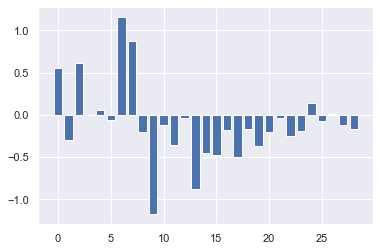

In [102]:
# logistic regression for feature importance of data
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
# define dataset
X=datastd.drop('Price',axis=1)
y=data["Price"] # define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
column = datastd.columns
for i,v in enumerate(importance):
	print(str(column[i]) + ' [%0d], Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Observamos que casi todas las variables que tenemos van a tener una alta influencia en la variable a predecir. Aunque podemos observar que las variables: Bathrooms, Property Type, Room Type y Amenities destacan sobre el resto. Es interesante esto pues puede ser una buena muestra de que a las personas lo que más les importa a la hora de coger un Airbnb es, lógicamente, la clase de propiedad que van a alquilar y el tipo de habitación. Pero también el número de baños que haya y las comodidades que ofrezca y, por lo tanto, eso dispara el precio de alquiler.

Observamos que variables como Host Response Rate y Host Since también presentan relación con el precio del Airbnb. Por lo que la disponibilidad del arrendador es importante a la hora de establecer el precio de alquiler, curioso cuanto menos.

Sin embargo, la ciudad y el país donde se encuentra el Airbnb importa poco en su precio. Parece ser que no hay ciudades ni países más preponderantes sobre otras que inflen de manera notable el precio (que se recojan en este dataset). Esto puede tener sentido pues en esta base de datos, las ciudades que aparecían eran bastante importantes todas por lo que no debería de haber diferencias entre ellas.

Por último, observemos una cosa muy sorprendente. Parece ser que todas las variables relacionadas con las reseñas (Review Scores Rating, Number of Reviews y Reviews per Month) tienen poquísima importancia con el precio de alquiler. Parece ser que la gente no lee las reseñas de otras personas, o, simplemente, no les importan mucho. Nos ha parecido verdaderamente interesante.

## 5. Métricas

Para la correcta clasificación de los modelos de predicción vamos a definir algunas funciones que nos van a permitir medir el índice de predicción de cada algoritmo para así poder compararlos entre sí. Al ser la variable a predecir continua, vamos a utilizar métricas como el el error cuadrático medio y el R2 score. Además vamos a crear 4 funciones que van a calcular el porcentaje de aciertos con, respectivamente, 5€ de margen, 10€ de margen, 20€ de margen y 40€ de margen. Por último también vamos a calcular la medida accuracy exacta, es decir, el porcentaje de veces que acierta el precio EXACTO del Airbnb. Por la dificultad de esto último, esta medida nunca va a ser muy alta.

In [136]:
from sklearn.metrics import mean_squared_error, r2_score

def acc(test, predicciones):
    test_rounded = list(np.round(test))
    acc = np.mean(test_rounded == predicciones)*100
    return np.round(acc, 3)

def acc_5(test, predicciones):
    acc = []
    j = 0
    for i in y_data_test:
        interval = [i]
        for n in range(1,5):
            interval.append(i-n)
            interval.append(i+n)
        acc.append(interval.__contains__(np.round(predicciones[j])))
        j = j + 1
    return np.round(np.mean(acc)*100, 3)

def acc_10(test, predicciones):
    acc = []
    j = 0
    for i in y_data_test:
        interval = [i]
        for n in range(1,10):
            interval.append(i-n)
            interval.append(i+n)
        acc.append(interval.__contains__(np.round(predicciones[j])))
        j = j + 1
    return np.round(np.mean(acc)*100, 3)

def acc_20(test, predicciones):
    acc = []
    j = 0
    for i in y_data_test:
        interval = [i]
        for n in range(1,20):
            interval.append(i-n)
            interval.append(i+n)
        acc.append(interval.__contains__(np.round(predicciones[j])))
        j = j + 1
    return np.round(np.mean(acc)*100, 3)

def acc_40(test, predicciones):
    acc = []
    j = 0
    for i in y_data_test:
        interval = [i]
        for n in range(1,40):
            interval.append(i-n)
            interval.append(i+n)
        acc.append(interval.__contains__(np.round(predicciones[j])))
        j = j + 1
    return np.round(np.mean(acc)*100, 3)

## 5. Regresión lineal

Comencemos la introducción de los modelos de predicción con uno de los más sencillos pero que da resultados bastante decentes: la regresión lineal. Como nuestra variable a predecir es continua, pensamos que puede dar resultados interesantes. Puede que incluso mejores que la conocida regresión logística, ya que la variable Price no es binaria. Lo veremos más adelante.

### Regresión Lineal Simple (1 variable)

Comenzaremos haciendo una variable lineal simple con la variable Property Type, pues es la que nos ha dado un valor más alto en el análisis de importancia. Así podemos dibujar los resultados y mostrar cómo va a funcionar este modelo cuando introduzcamos más variables.

In [104]:
# Importamos las librerias que vamos a usar
from sklearn import linear_model

# Creamos el objeto de Regresión Linear
regr = linear_model.LinearRegression()

# Entrenamos nuestro modelo
regr.fit(X_data['Property Type'].values.reshape(-1, 1), y_data)

# Hacemos las predicciones que en definitiva una línea (en este caso, al ser 2D)
y_pred=regr.predict(X_data_test['Property Type'].values.reshape(-1, 1))

# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio
print("Root Mean squared error: %.2f" % np.sqrt(mean_squared_error(y_data_test, y_pred)))
# Puntaje de Varianza. El mejor puntaje es un 1.0
print('Variance score: %.2f' % r2_score(y_data_test, y_pred))

Coefficients: 
 [1.35851516]
Independent term: 
 70.43333096741505
Root Mean squared error: 70.21
Variance score: 0.00


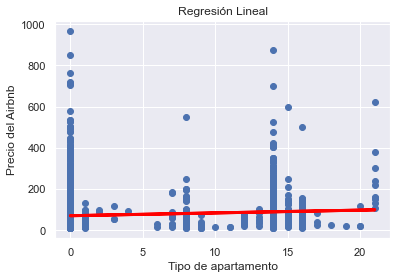

In [105]:
plt.scatter(X_data_test['Property Type'], y_data_test)
plt.plot(X_data_test['Property Type'], y_pred, color='red', linewidth=3)

plt.xlabel('Tipo de apartamento')
plt.ylabel('Precio del Airbnb')
plt.title('Regresión Lineal')

plt.show()

Evidentemente, nos da unos resultados muy malos, pues estamos utilizando una sóla variable para predecir. Sin embargo ya vemos cómo va a funcionar la regresión simple. Hagamos esto mismo utilizando todas las variables.

### Regresión lineal múltiple

In [106]:
# Creamos un nuevo objeto de Regresión Lineal
regr2 = linear_model.LinearRegression()

# Entrenamos el modelo, esta vez, con 30 dimensiones
# obtendremos 30 coeficientes, lo que nos hace imposible graficar nada
regr2.fit(X_data, y_data)

# Hacemos la predicción con la que tendremos puntos sobre el plano hallado
t_pred = regr2.predict(X_data_test)

# Los coeficientes
print('Coefficients: \n', regr2.coef_)
# Error cuadrático medio
print("Root Mean squared error: %.2f" % np.sqrt(mean_squared_error(y_data_test, t_pred)))
# Evaluamos el puntaje de varianza (siendo 1.0 el mejor posible)
print('Variance score: %.2f' % r2_score(y_data_test, t_pred))

Coefficients: 
 [-2.60675921e-03  1.20977513e+00 -1.04133277e-01 -7.53085881e-01
  1.93724137e-01 -1.56291770e+00  4.79848533e-01 -2.78487604e+01
  8.17938012e+00  1.72119810e+01  1.35693426e+01 -2.43412939e+00
 -4.57892812e+00 -2.98912092e-01 -9.95863067e-03  6.90950081e-01
 -1.26794510e+00  1.06593827e-01 -2.11951343e-01 -1.25230003e-03
  3.88414800e-02  1.42714091e+00 -1.30100267e-01 -6.64157008e-03
  4.40915338e-02  7.90706233e-01 -1.09825805e+00  1.15176294e-01
 -2.64053504e+00]
Root Mean squared error: 52.25
Variance score: 0.45


¡¡Obtenemos una Variance score de 0.45!! Es un resultado bastante bueno (hay que tener en cuenta que el mejor posible es 1)

Veamos cuánto mejoramos con respecto al realizado con una sóla variable:

In [107]:
mejoraEnError = mean_squared_error(y_data_test, y_pred) - mean_squared_error(y_data_test, t_pred)
print(mejoraEnError)

2199.121173426666


In [108]:
mejoraEnVarianza = r2_score(y_data_test, t_pred) - r2_score(y_data_test, y_pred)
print(mejoraEnVarianza)

0.4442181518476943


Hemos reducido el error en casi 2200 unidades y la varianza en casi el 45%, una barbaridad. Está claro que el primer modelo era muy muy malo.

Vamos a ver el porcentaje de aciertos con las funciones que creamos anteriormente.

In [138]:
print('Acertamos exactamente el', acc(y_data_test, t_pred),'% de las predicciones.')

print('Acertamos con un margen de 5€ el', acc_5(y_data_test, t_pred),'% de las predicciones.')

print('Acertamos con un margen de 10€ el', acc_10(y_data_test, t_pred),'% de las predicciones.')

print('Acertamos con un margen de 20€ el', acc_20(y_data_test, t_pred),'% de las predicciones.')

print('Acertamos con un margen de 40€ el', acc_40(y_data_test, t_pred),'% de las predicciones.')

Acertamos exactamente el 0.0 % de las predicciones.
Acertamos con un margen de 5€ el 13.275 % de las predicciones.
Acertamos con un margen de 10€ el 28.81 % de las predicciones.
Acertamos con un margen de 20€ el 52.216 % de las predicciones.
Acertamos con un margen de 40€ el 80.077 % de las predicciones.


Bueno, no son resultados completamente horribles, pero cometemos bastantes errores. Vamos a crear un dataframe donde vamos a ir guardando las predicciones que hagamos con todos los modelos para tener al final una forma fácil de ver todo lo que hemos hecho y pasemos al siguiente modelo.

In [243]:
predicciones = pd.DataFrame({'Real Price':y_data_test, 'Linear Regresion':t_pred})

In [244]:
predicciones.head(10)

Real Price  Linear Regresion
1136         50.0        102.964606
10957        45.0         87.498803
1884        110.0        124.736217
7724         70.0         47.539334
13178        49.0         77.317459
12663        55.0         67.674578
681         105.0         47.425280
9167         80.0         77.110246
10225        17.0         33.094569
5591        115.0        132.562207

## (EXTRA) Red neuronal

Como apartado extra, queremos probar a crear una red neuronal. Las redes neuronales son algoritmos de deep learning que obtienen resultados muy buenos a la hora de predecir pero perdiendo a cambio, explicatibilidad del modelo. Pues es complicado entender por qué los pesos óptimos son los que son dentro de las capas ocultas de la red neuronal.


### Una capa (0 capas ocultas)


Vamos a empezar realizando una red neuronal de una sóla capa (0 capas ocultas) para ver cómo funcionaría. 

Importamos la librería tensorflow para poder realizar redes neuronales, creamos la capa densa y se la aplicamos a nuestro modelo.

In [127]:
# pip install tensorflow
import tensorflow as tf

In [128]:
capa = tf.keras.layers.Dense(units = 1, input_shape=[29])
neural = tf.keras.Sequential([capa])
neural.compile(
  optimizer=tf.keras.optimizers.Adamax(0.1),
  loss="mean_squared_error"
)

Veamos cómo ha ido aprendiendo nuestra red neuronal en base a las iteraciones.

In [129]:
historico = neural.fit(X_data, y_data, epochs=100, verbose=False)

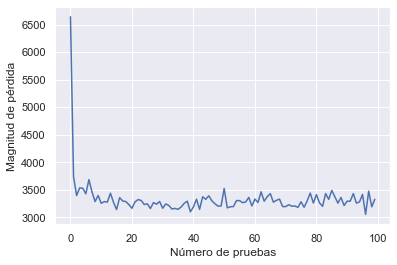

In [130]:
plt.xlabel("Número de pruebas")
plt.ylabel("Magnitud de pérdida")
plt.plot(historico.history["loss"])
plt.show()

Parece que a partir de la iteración 20 la red neuronal ya no ha mejorado en sus predicciones. Esto es porque la red ha obtenido ya unos valores para los pesos óptimos que minimizan el error cuadrático medio.

Veamos a ver cómo son las predicciones.

In [133]:
red_pred = neural.predict(X_data_test)

# Error cuadrático medio
print("Root Mean squared error: %.2f" % np.sqrt(mean_squared_error(y_data_test, red_pred)))

# Evaluamos el puntaje de varianza (siendo 1.0 el mejor posible)
print('Variance score: %.2f' % r2_score(y_data_test, red_pred))

139/139 [==============================] - 0s 1ms/step
Root Mean squared error: 56.73
Variance score: 0.35


Observamos que tanto el error como la varianza no nos salen valores muy buenos. Esto es normal, pues la red neuronal que hemos utilizado es lo más simple del mundo.

In [137]:
print('Acertamos exactamente el', acc(y_data_test, red_pred),'% de las predicciones.')

print('Acertamos con un margen de 5€ el', acc_5(y_data_test, red_pred),'% de las predicciones.')

print('Acertamos con un margen de 10€ el', acc_10(y_data_test, red_pred),'% de las predicciones.')

print('Acertamos con un margen de 20€ el', acc_20(y_data_test, red_pred),'% de las predicciones.')

print('Acertamos con un margen de 40€ el', acc_40(y_data_test, red_pred),'% de las predicciones.')

Acertamos exactamente el 0.0 % de las predicciones.
Acertamos con un margen de 5€ el 10.742 % de las predicciones.
Acertamos con un margen de 10€ el 22.23 % de las predicciones.
Acertamos con un margen de 20€ el 44.12 % de las predicciones.
Acertamos con un margen de 40€ el 76.594 % de las predicciones.


No nos salen resultados demasiado buenos, vamos a aumentar el número de iteracciones, aunque parece que a partir de 20 el modelo ya no mejora, pero por confirmar.

In [139]:
capa = tf.keras.layers.Dense(units = 1, input_shape=[29])
neural = tf.keras.Sequential([capa])
neural.compile(
  optimizer=tf.keras.optimizers.Adamax(0.1),
  loss="mean_squared_error"
)

In [140]:
historico = neural.fit(X_data, y_data, epochs=1000, verbose=False)

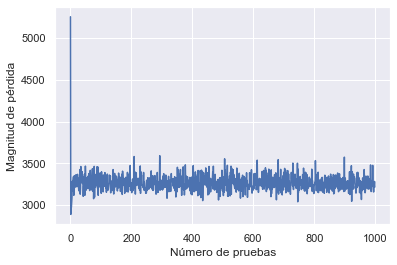

In [141]:
plt.xlabel("Número de pruebas")
plt.ylabel("Magnitud de pérdida")
plt.plot(historico.history["loss"])
plt.show()

In [142]:
red_pred = neural.predict(X_data_test)

# Error cuadrático medio
print("Root Mean squared error: %.2f" % np.sqrt(mean_squared_error(y_data_test, red_pred)))

# Evaluamos el puntaje de varianza (siendo 1.0 el mejor posible)
print('Variance score: %.2f' % r2_score(y_data_test, red_pred))

139/139 [==============================] - 0s 2ms/step
Root Mean squared error: 53.56
Variance score: 0.42


In [137]:
print('Acertamos exactamente el', acc(y_data_test, red_pred),'% de las predicciones.')

print('Acertamos con un margen de 5€ el', acc_5(y_data_test, red_pred),'% de las predicciones.')

print('Acertamos con un margen de 10€ el', acc_10(y_data_test, red_pred),'% de las predicciones.')

print('Acertamos con un margen de 20€ el', acc_20(y_data_test, red_pred),'% de las predicciones.')

print('Acertamos con un margen de 40€ el', acc_40(y_data_test, red_pred),'% de las predicciones.')

Acertamos exactamente el 0.0 % de las predicciones.
Acertamos con un margen de 5€ el 10.742 % de las predicciones.
Acertamos con un margen de 10€ el 22.23 % de las predicciones.
Acertamos con un margen de 20€ el 44.12 % de las predicciones.
Acertamos con un margen de 40€ el 76.594 % de las predicciones.


Observamos que ya no hace mejores predicciones a pesar de que metamos más iteraciones. Pero observemos que hemos realizado la red neuronal con datos que no están estandarizados, es posible que el modelo no esté saliendo muy bueno porque esté dando peso a variables muy grandes pero que en realidad no tienen relacion con la variable Price. Utilicemos los datos de entrenamiento estandarizados.

In [169]:
capa = tf.keras.layers.Dense(units = 1, input_shape=[29])
neural = tf.keras.Sequential([capa])
neural.compile(
  optimizer=tf.keras.optimizers.Adamax(0.1),
  loss="mean_squared_error"
)

In [171]:
historico = neural.fit(X_datastd, y_datastd, epochs=100, verbose=False)

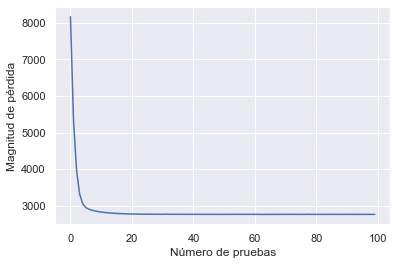

In [172]:
plt.xlabel("Número de pruebas")
plt.ylabel("Magnitud de pérdida")
plt.plot(historico.history["loss"])
plt.show()

In [204]:
red_pred = neural.predict(X_datastd_test)[:,0]

# Error cuadrático medio
print("Root Mean squared error: %.2f" % np.sqrt(mean_squared_error(y_data_test, red_pred)))

# Evaluamos el puntaje de varianza (siendo 1.0 el mejor posible)
print('Variance score: %.2f' % r2_score(y_data_test, red_pred))

139/139 [==============================] - 0s 2ms/step
Root Mean squared error: 52.22
Variance score: 0.45


Ahora salen mejores valores para el error y la varianza pero aún no son muy buenos. Veamos el resto de métricas que hemos establecido.

In [205]:
print('Acertamos exactamente el', acc(y_data_test, red_pred),'% de las predicciones.')

print('Acertamos con un margen de 5€ el', acc_5(y_data_test, red_pred),'% de las predicciones.')

print('Acertamos con un margen de 10€ el', acc_10(y_data_test, red_pred),'% de las predicciones.')

print('Acertamos con un margen de 20€ el', acc_20(y_data_test, red_pred),'% de las predicciones.')

print('Acertamos con un margen de 40€ el', acc_40(y_data_test, red_pred),'% de las predicciones.')

Acertamos exactamente el 0.0 % de las predicciones.
Acertamos con un margen de 5€ el 13.297 % de las predicciones.
Acertamos con un margen de 10€ el 29.15 % de las predicciones.
Acertamos con un margen de 20€ el 52.465 % de las predicciones.
Acertamos con un margen de 40€ el 80.167 % de las predicciones.


Estos porcentajes son iguales que en la regresión lineal, veamos en un datframe ambas predicciones.

In [218]:
prueba = pd.DataFrame({'Real Price Std':y_datastd_test, 'Linear Regresion':t_pred, 'Neural Network':red_pred})

In [219]:
prueba.head(10)

Real Price Std  Linear Regresion  Neural Network
1134             50.0        102.964606      102.125793
10928            45.0         87.498803       87.448097
1876            110.0        124.736217      123.931953
7704             70.0         47.539334       47.784538
13144            49.0         77.317459       77.358192
12630            55.0         67.674578       66.203819
681             105.0         47.425280       47.876091
9143             80.0         77.110246       77.274612
10199            17.0         33.094569       32.555992
5574            115.0        132.562207      132.382706

Observemos que obtenemos casi los mismos resultados que con la regresión lineal. Esto tiene sentido pues al haber hecho la red neuronal con una sóla capa y la misma función de pérdida que la regresión lineal, la red neuronal se entrena de igual forma que se crea el hiperplano de la regresión.

### Multicapa (una capa oculta o más)

La clave de una red neuronal radica en la posibilidad de introducir capas ocultas entre nuestrops datos y la salida final. De manera que podemos generar un modelo que resuelva de forma muy satisfactoria problemas no lineales.

Para hacer una buena red neuronal se han de tener en consideración bastantes parámetros, algunos de los más importantes son:

##### Número y tamaño de capas


La arquitectura de una red, el número de capas y el número de neuronas que forman parte de cada capa, determinan en gran medida la complejidad del modelo y con ello su potencial capacidad de aprendizaje.

La capa de entrada y salida son sencillas de establecer. La capa de entrada tiene tantas neuronas como predictores y la capa de salida tiene una neurona en problemas de regresión y tantas como clases en problemas de clasificación. En la mayoría de implementaciones, estos valores se establecen automáticamente en función del conjunto de entrenamiento. Por lo que nosotros sólo deberemos establecer únicamente el número de capas intermedias (ocultas) y el tamaño de las mismas.

Cuantas más neuronas y capas, mayor la complejidad de las relaciones que puede aprender el modelo. Sin embargo, dado que en cada neurona está conectada por pesos al resto de neuronas de las capas adyacentes, el número de parámetros a aprender aumenta y con ello el tiempo de entrenamiento. Por ello nosotros probaremos únicamente con 1 y dos capas ocultas.


##### Learning rate


El learning rate o ratio de aprendizaje establece cómo de rápido pueden cambiar los parámetros de un modelo a medida que se optimiza (aprende). Este hiperparámetro es uno de los más complicados de establecer, ya que depende mucho de los datos e interacciona con el resto de hiperparámetros. Si el learning rate es muy grande, el proceso de optimización puede ir saltando de una región a otra sin que el modelo sea capaz de aprender. Si por el contrario, el learning rate es muy pequeño, el proceso de entrenamiento puede tardar demasiado y no llegar a completarse.Algunas de las recomendaciones heurísticas basadas en prueba y error son:

Utilizar un learning rate lo más pequeño posible siempre y cuando el tiempo de entrenamiento no supere las limitaciones temporales disponibles.

No utilizar un valor constante de learning rate durante todo el proceso de entrenamiento. Por lo general, utilizar valores mayores al inicio y pequeños al final.


##### Algoritmo de optimización


El descenso de gradiente y el descenso de gradiente estocástico fueron de los primeros métodos de optimización utilizados para entrenar modelos de redes neuronales. Ambos utilizan directamente el gradiente para dirigir la optimización. Pronto se vio que esto genera problemas a medida que las redes aumentan de tamaño (neuronas y capas). En muchas regiones del espacio de búsqueda, el gradiente es muy proximo a cero, lo que hace que la optimización quede estancada en estas regiones. Para evitar este problema, se han desarrollado modificaciones del descenso de gradiente capaces de adaptar el learning rate en función del gradiente y subgradiente. De esta forma, el proceso de aprendizaje se ralentiza o acelera dependiendo de las características de la región del espacio de búsqueda en el que se encuentren. Aunque existen multitud de adaptaciones, suele recomendarse:

Para conjuntos de datos pequeños: l-bfgs

Para conjuntos de datos grandes: adam o rmsprop

La elección del algoritmo de optimización puede tener un impacto muy grande en el aprendizaje de los modelos, sobretodo en deep learning. Nosotros tenenmos más de 10000 observaciones por lo que nos podemos permitir el lujo de utilizar adam.

##### Regularización


Los métodos de regularización se utilizan con el objetivo de reducir el sobreajuste (overfitting) de los modelos. Un modelo con sobreajuste memoriza los datos de entrenamiento pero es incapaz de predecir correctamente nuevas observaciones.

Los modelos de redes neuronales pueden considerarse como modelos sobre parametrizados, por lo tanto, las estrategias de regularización son fundamentales. De entre las muchas que existen, destacan la regularización L1 y L2 (weight decay), y el dropout.

1. Penalización L1 y L2
El objetivo de la penalización L1 y L2, esta última también conocida como weight decay, es evitar que los pesos tomen valores excesivamente elevados. De esta forma se evita que unas pocas neuronas dominen el comportamiento de la red y se fuerza a que las características poco informativas (ruido) tengan pesos próximos o iguales a cero.


2. Dropout
El proceso consiste en de desactivar aleatoriamente una serie de neuronas durante el proceso de entrenamiento. En concreto, durante cada iteración del entrenamiento, se ponen a cero los pesos de una fracción aleatoria de neuronas por capa. El método de dropout, descrito por Srivastava et al. en 2014, se ha convertido en un estándar para entrenar redes neuronales. El porcentaje de neuronas que suele desactivarse por capa (dropout rate) suele ser un valor entre 0.2 y 0.5.


Buscar todos estos parámetros a mano es tedioso y muy lento, vamos a generar una búsqueda por validación cruzada que lo haga automáticamente y nos devuelva cuáles son los mejores.

Necesitaremos las siguientes librerías.

In [222]:
# Gráficos
# ==============================================================================
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

# Modelado
# ==============================================================================
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import set_config
import multiprocessing

Creamos los espacios de búsqueda, generamos una pipeline que contenga el modelo que vamos a utilizar (usamos adam pues tenemos muchos datos), inicializamos el grid y lo mostramos en un datset ordenado de manera que la primera línea sea la que da los mejores resultados.

(No recomiendo correr esta parte del código en su ordenador pues a mi me tardó 15 minutos en completarse)

In [231]:
# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {
    'modelo__hidden_layer_sizes': [(10), (20), (10, 10)],
    'modelo__alpha': np.logspace(-3, 3, 10),
    'modelo__learning_rate_init': [0.001, 0.01],
}

# Pipeline que definirá el modelo
# ==============================================================================
pipe = Pipeline([('modelo', MLPRegressor(solver = 'adam', max_iter= 100))])

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 50,
        scoring    = 'neg_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_datastd, y = y_datastd)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

param_modelo__learning_rate_init param_modelo__hidden_layer_sizes  \
11                             0.01                               20   
2                              0.01                               20   
1                              0.01                               20   
37                             0.01                               20   
24                             0.01                               20   
3                              0.01                               10   
35                            0.001                               20   
21                            0.001                               20   
49                            0.001                               20   
47                             0.01                               20   

   param_modelo__alpha  mean_test_score  std_test_score  mean_train_score  \
11            0.464159     -1826.030896      190.978783      -1352.184403   
2             0.021544     -1833.496541      212.226487      -1363.847204   
1                 10.0     -1842.124589      192.684413      -1361.362484   
37               0.001     -1848.645358      209.140970      -1376.133815   
24                 0.1     -1855.953012      199.673450      -1386.645574   
3             2.154435     -1869.100803      182.577962      -1550.280014   
35                 0.1     -1869.194622      220.984388      -1520.925110   
21           46.415888     -1876.990966      222.526447      -1556.888500   
49            2.154435     -1878.545162      208.927424      -1534.898780   
47            0.004642     -1891.111647      189.754431      -1391.944955   

    std_train_score  
11        57.644725  
2         68.953520  
1         99.081337  
37       102.838916  
24        55.011788  
3         42.785947  
35        45.090886  
21        45.916609  
49        74.771163  
47        46.935783

Parece que la red neuronal funciona mejor cuando aprende con un ratio de aprendizaje constante de 0.01, con una sóla capa oculta de 20 neuronas (de las tres que hemos probado pues el coste computacional era muy alto, a lo mejor si hubierámos probado más combinaciones habría salido algo mejor) y un valor de alpha de 0.46 aproximadamente.

Podemos ver mejor todos los hiperparámetros utilizados si hacemos un .get_params().

In [248]:
neural_final = grid.best_estimator_
neural_final['modelo'].get_params()

{'activation': 'relu',
 'alpha': 0.46415888336127775,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 20,
 'learning_rate': 'constant',
 'learning_rate_init': 0.01,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

Hagamos las predicciones con éste modelo y comprobemos el error y la varianza a ver si hemos conseguido mejores resultados.

In [239]:
neural_final_pred = neural_final.predict(X = X_datastd_test)

# Error cuadrático medio
print("Root Mean squared error: %.2f" % np.sqrt(mean_squared_error(y_datastd_test, neural_final_pred)))

# Evaluamos el puntaje de varianza (siendo 1.0 el mejor posible)
print('Variance score: %.2f' % r2_score(y_datastd_test, neural_final_pred))

Root Mean squared error: 42.39
Variance score: 0.64


Tenemos una varianza de 0.64, es un resultado buenísimo. Y también hemos reducido el error con respecto a los demás modelos, parece que hemos conseguido una buena red neuronal. Veamos qué tal predice nuestra variable objetivo con las métricas que hemos creado.

In [240]:
print('Acertamos exactamente el', acc(y_data_test, neural_final_pred),'% de las predicciones.')

print('Acertamos con un margen de 5€ el', acc_5(y_data_test, neural_final_pred),'% de las predicciones.')

print('Acertamos con un margen de 10€ el', acc_10(y_data_test, neural_final_pred),'% de las predicciones.')

print('Acertamos con un margen de 20€ el', acc_20(y_data_test, neural_final_pred),'% de las predicciones.')

print('Acertamos con un margen de 40€ el', acc_40(y_data_test, neural_final_pred),'% de las predicciones.')

Acertamos exactamente el 0.0 % de las predicciones.
Acertamos con un margen de 5€ el 17.187 % de las predicciones.
Acertamos con un margen de 10€ el 34.441 % de las predicciones.
Acertamos con un margen de 20€ el 62.506 % de las predicciones.
Acertamos con un margen de 40€ el 85.617 % de las predicciones.


Hemos subido las predicciones en todos los casos con respecto a los modelos anteriores. La única desventaja, es que interpretar la capa oculta de nuestra red neuronal será muy difícil y aunque hayamos conseguido mejores resultados hemos perdido explicatibilidad con respecto a los demás algoritmos.

Introduzcamos estas nuevas predicciones en nuestro dataset y veamos cómo nos queda finalmente.

In [250]:
predicciones['Neural Network']=neural_final_pred
predicciones.head(10)

Real Price  Linear Regresion  Neural Network
1136         50.0        102.964606       45.173087
10957        45.0         87.498803       78.086453
1884        110.0        124.736217       85.876935
7724         70.0         47.539334       54.998372
13178        49.0         77.317459       90.054872
12663        55.0         67.674578       49.265387
681         105.0         47.425280      114.581441
9167         80.0         77.110246       85.791483
10225        17.0         33.094569       41.367125
5591        115.0        132.562207      103.415142